# 🧑‍💻 Setup


In [1]:
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install scipy # for ranked correlation check
!pip install scikit-learn # advanced analisis
!pip install statsmodels #ml

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.stats import ks_2samp
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

# Funtions

In [5]:
def random_sample_impute(df, column):
    np.random.seed(42)
    non_null_values = df[column].dropna()
    missing_mask = df[column].isna()
    imputed_values = np.random.choice(non_null_values, size=missing_mask.sum(), replace=True)
    df.loc[missing_mask, column] = imputed_values
    return df

def apply_random_imputation(df, columns):
    df_imputed = df.copy()
    for col in columns:
        df_imputed = random_sample_impute(df_imputed, col)
    return df_imputed

def plot_overlay_histogram_kde(df_before, df_after, column, bins=20):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].hist(df_before[column].dropna(), bins=bins, alpha=0.6, label='Before', edgecolor='black')
    axes[0].hist(df_after[column], bins=bins, alpha=0.6, label='After', edgecolor='black')
    axes[0].set_title(f'Histogram Overlay: {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    sns.kdeplot(data=df_before, x=column, label='Before', fill=True, ax=axes[1])
    sns.kdeplot(data=df_after, x=column, label='After', fill=True, ax=axes[1])
    axes[1].set_title(f'KDE Overlay: {column}')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Density')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def ks_test_imputation(df_original, df_imputed, column):
    ks_stat, p_value = ks_2samp(df_original[column].dropna(), df_imputed[column])
    print(f"KS Test for {column}: KS Statistic={ks_stat:.4f}, p-value={p_value:.4f}\n")


def summarize_imputation(df_original, df_imputed, column):
    summary = pd.DataFrame({
        'Before Imputation': df_original[column].dropna().describe(),
        'After Imputation': df_imputed[column].describe()
    })
    print(f"\nSummary Statistics for {column}:\n{summary}\n")


In [6]:
def validate_numerical_columns(df):
    numerical_ranges = {
        'Attendance (%)': (0, 100),
        'Midterm_Score': (0, 100),
        'Final_Score': (0, 100),
        'Assignments_Avg': (0, 100),
        'Quizzes_Avg': (0, 100),
        'Participation_Score': (0, 10),
        'Projects_Score': (0, 100),
        'Total_Score': (0, 100)
    }
    valid = True
    for col, (min_val, max_val) in numerical_ranges.items():
        if col in df.columns:
            invalid_count = ((df[col] < min_val) | (df[col] > max_val)).sum()
            if invalid_count > 0:
                print(f"Error: {col} has {invalid_count} invalid entries (allowed range: {min_val}-{max_val}).")
                valid = False
        else:
            print(f"Error: {col} column not found.")
            valid = False
    return valid

def validate_grade_column(df):
    allowed_grades = ['A', 'B', 'C', 'D', 'F']
    if 'Grade' in df.columns:
        invalid_grades = df[~df['Grade'].isin(allowed_grades)]['Grade'].unique()
        if len(invalid_grades) > 0:
            print("Error: Invalid Grade entries found:")
            for grade in invalid_grades:
                print(f"  {grade}")
            return False
    else:
        print("Error: Grade column not found.")
        return False
    return True

def validate_data(df):
    valid_num = validate_numerical_columns(df)
    valid_grade = validate_grade_column(df)
    if valid_num and valid_grade:
        print("\033[92m ✅ Success - Not found element out of range  ✔\033[0m")
    else:
        print("Validation failed.")

In [7]:
def check_duplicates(df, columns):
    for col in columns:
        if col in df.columns:
            duplicates = df[df.duplicated(subset=[col], keep=False)]
            if duplicates.empty:
                print(f"{col}: \033[92m ✅ Success - No Duplicated Elements.\033[0m")
            else:
                print(f"Number of duplicate {col} entries: {duplicates.shape[0]}")
                print(f"Sample of duplicate {col} entries:")
                print(duplicates[[col]].head(10))
            print()
        else:
            print(f"{col} column not found in the DataFrame.\n")


In [8]:
def clean_columns_names(df):
    clean_columns = {col: col.strip().replace(' ', '_').lower() for col in df.columns}
    df.rename(columns=clean_columns, inplace=True)
    
    df.rename(columns={'stress_level_(1-10)': 'stress_level'}, inplace=True)
    
    if 'attendance_(%)' in df.columns:
        df.rename(columns={'attendance_(%)': 'attendance'}, inplace=True)
    elif 'attendance' not in df.columns:
        print("Attendance column not found. Skipping engagement score calculation.")
    
    return df


In [9]:
def extract_categorical_distribution(df, categorical_cols):
    distributions = []
    
    for col in categorical_cols:
        counts = df[col].value_counts(dropna=False).sort_values(ascending=False)
        percentages = (counts / counts.sum()) * 100
        temp_df = pd.DataFrame({
            'Count': counts,
            'Percentage': percentages.round(2)
        })
        temp_df.index.name = col
        distributions.append(temp_df)
        
        print(f"Category: {col}")
        print(temp_df)
        print("-" * 42)
    
    categorical_distribution = pd.concat(distributions, keys=categorical_cols)

def get_summary_statistics(df, numerical_cols):
    summary = df[numerical_cols].describe().T
    summary["skewness"] = df[numerical_cols].skew()
    summary["kurtosis"] = df[numerical_cols].kurt()
    return summary.round(5)

def explore_variable(df, col):
    summary_stats = get_summary_statistics(df, [col])
    stats_t = summary_stats.T
    
    fig, axes = plt.subplots(
        1, 3, 
        figsize=(15, 5), 
        gridspec_kw={'width_ratios': [2.2, 2.2, 1]}
    )
    
    sns.histplot(df[col].dropna(), bins=25, ax=axes[0], color='skyblue', kde=True)
    for line in axes[0].lines:
        line.set_color('red')
    axes[0].set_title(f'Distribution of {col}', fontsize=14)
    axes[0].set_xlabel(col, fontsize=12)
    
    sns.boxplot(x=df[col].dropna(), ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot of {col}', fontsize=14)
    axes[1].set_xlabel(col, fontsize=12)
    
    axes[2].axis('off')
    table = axes[2].table(
        cellText=stats_t.values,
        rowLabels=stats_t.index,
        colLabels=stats_t.columns,
        loc='center',
        colWidths=[0.8]
        
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(0.8, 1.2)
    plt.tight_layout()
    plt.show()
    
def explore_all_numerical_variables(df, numerical_columns):
    for col in numerical_columns:
        explore_variable(df, col)

In [50]:
def get_categorical_distribution(df, col):
    counts = df[col].value_counts(dropna=False)
    percentages = (counts / counts.sum() * 100).round(2)
    summary_df = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    })
    return summary_df


def plot_categorical_distribution(summary_df, col):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    pie_colors = sns.color_palette("pastel", n_colors=len(summary_df))
    axes[0].pie(
        summary_df['Count'],
        labels=summary_df.index.astype(str),
        autopct='%1.1f%%',
        startangle=90,
        colors=pie_colors
    )
    axes[0].axis('equal')
    axes[0].set_title(f'Pie Chart for {col}', fontsize=14)
    
    axes[1].axis('off')
    table = axes[1].table(
        cellText=summary_df.values,
        rowLabels=summary_df.index.astype(str),
        colLabels=summary_df.columns,
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.0, 1.2)
    
    plt.tight_layout()
    plt.show()


def explore_categorical_variable(df, col):
    summary_df = get_categorical_distribution(df, col)
    plot_categorical_distribution(summary_df, col)

def explore_all_categorical_variables(df, categorical_columns):
    for col in categorical_columns:
        explore_categorical_variable(df, col)

In [10]:
def transform_data(df, make_copy):
    if make_copy:
        df_transformed = df.copy()
    else:
        df_transformed = df
    
    grade_mapping = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'F': 1}
    if 'Grade' in df_transformed.columns:
        df_transformed['grade_numeric'] = df_transformed['Grade'].map(grade_mapping)
    
    numeric_columns = [
        'Age', 
        'Attendance (%)', 
        'Midterm_Score', 
        'Final_Score', 
        'Assignments_Avg', 
        'Quizzes_Avg', 
        'Participation_Score', 
        'Projects_Score', 
        'Total_Score', 
        'Study_Hours_per_Week', 
        'Stress_Level', 
        'Sleep_Hours_per_Night'
    ]
    numeric_cols_present = [col for col in numeric_columns if col in df_transformed.columns]
    if numeric_cols_present:
        df_transformed[numeric_cols_present] = df_transformed[numeric_cols_present].apply(pd.to_numeric, errors='coerce')
    
    binary_columns = ['Extracurricular_Activities', 'Internet_Access_at_Home']
    for col in binary_columns:
        if col in df_transformed.columns:
            df_transformed[col] = df_transformed[col].map({'Yes': True, 'No': False})
            
    parent_education_mapping = {
        'Unknown': 0,
        'High School': 1,
        "Bachelor's": 2,
        "Master's": 3,
        'PhD': 4
    }
    if 'Parent_Education_Level' in df_transformed.columns:
        df_transformed['Parent_Education_Level_Num'] = df_transformed['Parent_Education_Level'].map(parent_education_mapping)
    
    family_income_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    if 'Family_Income_Level' in df_transformed.columns:
        df_transformed['Family_Income_Level_Num'] = df_transformed['Family_Income_Level'].map(family_income_mapping)
        
    return df_transformed

In [11]:
def compute_correlation_matrices(df, score_columns):
    corr_spearman = df[score_columns].corr(method='spearman')
    corr_kendall = df[score_columns].corr(method='kendall')
    return corr_spearman, corr_kendall

In [12]:
def compute_grade(score):
    if score >= 90:
        return 'A'
    elif score >= 80:
        return 'B'
    elif score >= 70:
        return 'C'
    elif score >= 60:
        return 'D'
    else:
        return 'F'

In [13]:
def plot_scatter_with_regression(df, x_col, y_col, title=None):
    plt.figure(figsize=(8, 6))
    
    plt.scatter(df[x_col], df[y_col], alpha=0.7, label='Data points')
    
    x = df[x_col].dropna()
    y = df[y_col].dropna()
    m, b = np.polyfit(x, y, 1)
    
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = m * x_vals + b
    plt.plot(x_vals, y_vals, color='red', label='Regression Line')
    
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title if title else f"{y_col} vs {x_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:

def plot_boxplots(df, columns):
    cols = 3
    rows = (len(columns) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i], color='lightgreen')
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_categorical_distributions(df, columns):
    cols = 4
    rows = (len(columns) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        order = df[col].value_counts().index
        sns.countplot(x=df[col], order=order, ax=axes[i], hue=df[col], palette='viridis', legend=False)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_multiple_heatmaps(corr_matrices, titles=None):

    num_matrices = len(corr_matrices)
    
    if num_matrices == 0:
        print("No correlation matrices provided.")
        return
    
    if titles is None:
        titles = [f"Correlation Heatmap {i+1}" for i in range(num_matrices)]
    
    if num_matrices == 1:
        fig, ax = plt.subplots(figsize=(7, 7))
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, num_matrices, figsize=(7 * num_matrices, 7))
    
    for i, (corr_matrix, title) in enumerate(zip(corr_matrices, titles)):
        sns.heatmap(
            corr_matrix,
            annot=True,
            annot_kws={"fontsize": 8},
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            ax=axes[i],
            vmin=-1,
            vmax=1,
            center=0,
            square=True
        )
        axes[i].set_title(title)
        
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()

def plot_scatter(df, x_y_pairs, hue_col=None, palette='viridis', alpha=0.6, 
                 highlight_df=None, highlight_color='red', highlight_size=100, 
                 legend_title=None):
    cols = 3
    rows = (len(x_y_pairs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    axes = axes.flatten()

    for i, (x_col, y_col) in enumerate(x_y_pairs):
        ax = axes[i]
        
        if hue_col:
            hue_values = df[hue_col].astype(str)
            curr_palette = sns.color_palette(palette, n_colors=len(hue_values.unique()))
            if i == 0:
                sns.scatterplot(x=x_col, y=y_col, data=df, hue=hue_values,
                                palette=curr_palette, alpha=alpha, legend="full", ax=ax)
            else:
                sns.scatterplot(x=x_col, y=y_col, data=df, hue=hue_values,
                                palette=curr_palette, alpha=alpha, legend=False, ax=ax)
        else:
            sns.scatterplot(x=x_col, y=y_col, data=df, alpha=alpha, ax=ax)

        if highlight_df is not None:
            sns.scatterplot(x=highlight_df[x_col], y=highlight_df[y_col],
                            color=highlight_color, s=highlight_size, label='Highlighted', ax=ax)

        ax.set_title(f'Scatter Plot: {x_col} vs {y_col}')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    if hue_col:
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, title=legend_title if legend_title else hue_col,
                   loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels))
        plt.subplots_adjust(top=0.80)

    plt.tight_layout()
    plt.show()

In [15]:
def find_efficient_students(df, study_hours_col, score_col, high_score_threshold, score):
    median_study_hours = df[study_hours_col].median()
    efficient_students = df[(df[score_col] > high_score_threshold) & (df[study_hours_col] < median_study_hours) & (df['Total_Score'] > score)]
    other_students = df[(df[score_col] <= high_score_threshold) & (df[study_hours_col] >= median_study_hours) & (df['Total_Score'] <= score)]
    
    print(f"Median Study Hours per Week: {median_study_hours}")
    print(f"Number of efficient students (high score with low study hours): {efficient_students.shape[0]}")
    
    return efficient_students, other_students, median_study_hours

In [16]:
def detect_outliers_IQR(df, numeric_columns):
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if df[(df[col] < lower_bound) | (df[col] > upper_bound)].empty:
            print(f" ✅ No outliers in column: {col}")
        else:
            print(f" ❌? Outliers detected in column: {col}")


In [17]:
def rename_matrix(corr_matrix):
    rename_dict = {
        'Attendance (%)': 'Attendance',
        'Midterm_Score': 'Midterm',
        'Final_Score': 'Final',
        'Assignments_Avg': 'Assignments',
        'Quizzes_Avg': 'Quizzes',
        'Participation_Score': 'Participation',
        'Projects_Score': 'Projects',
        'Total_Score': 'Total',
        'Study_Hours_per_Week': 'StudyHours',
        'Stress_Level (1-10)': 'Stress',
        'Sleep_Hours_per_Night': 'Sleep',
        'Extracurricular_Activities_Ranked': 'Activities',
        'Internet_Access_at_Home_Ranked': 'Internet',
        'Family_Income_Level_Ranked': 'Income',
        'Grade_Ranked': 'Grade'
    }
    return corr_matrix.rename(index=rename_dict, columns=rename_dict)

def plot_pretty_heatmap(corr_matrix, title, rename=True):
    import seaborn as sns
    import matplotlib.pyplot as plt

    matrix = rename_matrix(corr_matrix) if rename else corr_matrix.copy()

    max_val = matrix.values[matrix.values != 1.0].max()
    min_val = matrix.values[matrix.values != 1.0].min()

    limit = max(abs(min_val), abs(max_val))

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-limit,
        vmax=limit,
        center=0,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        square=True
    )

    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def check_required_columns(df: pd.DataFrame):
    required_columns = [
        'Student_ID', 'First_Name', 'Last_Name', 'Email', 'Gender', 'Age',
        'Department', 'Attendance (%)', 'Midterm_Score', 'Final_Score',
        'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
        'Projects_Score', 'Total_Score', 'Grade', 'Study_Hours_per_Week',
        'Extracurricular_Activities', 'Internet_Access_at_Home',
        'Parent_Education_Level', 'Family_Income_Level', 'Stress_Level (1-10)',
        'Sleep_Hours_per_Night'
    ]

    missing = [col for col in required_columns if col not in df.columns]
    
    if missing:
        print("❌ Missing required columns:", missing)
        sys.exit("Execution stopped due to missing columns.")
    else:
        print("✅ All required columns are present.")

In [18]:
def plot_sleep_vs_attendance(df, sleep_threshold=7.7):
    df = df.copy()

    if 'Attendance (%)' not in df.columns:
        df['Attendance (%)'] = df['attendance'] * 100
    df['sleep_group'] = df['sleep_hours_per_night'].apply(
        lambda x: f'≥ {sleep_threshold} hrs' if x >= sleep_threshold else f'< {sleep_threshold} hrs'
    )

    palette = 'Set2'
    x_col = 'sleep_group'
    y_col = 'Attendance (%)'
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    sns.violinplot(data=df, x=x_col, y=y_col, hue=x_col, palette=palette,
                   inner='box', dodge=False, legend=False, ax=axes[0])
    axes[0].set_title('Violin Plot: Attendance by Sleep Group')
    axes[0].set_xlabel('Sleep Hours per Night')
    axes[0].set_ylabel('Attendance (%)')
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)

    sns.boxplot(data=df, x=x_col, y=y_col, hue=x_col, palette=palette,
                dodge=False, legend=False, ax=axes[1])
    axes[1].set_title('Boxplot: Attendance by Sleep Group')
    axes[1].set_xlabel('Sleep Hours per Night')
    axes[1].set_ylabel('')
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def plot_attendance_vs_grade_best(df, attendance_cutoff=87.35):
    df = df.copy()
    df['Attendance_Group'] = df['attendance'].apply(
        lambda x: f'≥ {attendance_cutoff:.2f}%' if x >= attendance_cutoff else f'< {attendance_cutoff:.2f}%'
    )

    palette = 'Set2'

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    sns.violinplot(data=df, x='Attendance_Group', y='grade', hue='Attendance_Group',
                   palette=palette, inner='box', dodge=False, legend=False, ax=axes[0])
    sns.stripplot(data=df, x='Attendance_Group', y='grade', color='black',
                  alpha=0.3, jitter=True, dodge=False, ax=axes[0])
    axes[0].set_title('Violin Plot: Grade by Attendance Group')
    axes[0].set_xlabel('Attendance Group')
    axes[0].set_ylabel('Grade')
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)

    sns.boxplot(data=df, x='Attendance_Group', y='grade', hue='Attendance_Group',
                palette=palette, dodge=False, legend=False, ax=axes[1])
    sns.stripplot(data=df, x='Attendance_Group', y='grade', color='black',
                  alpha=0.3, jitter=True, dodge=False, ax=axes[1])
    axes[1].set_title('Boxplot: Grade by Attendance Group')
    axes[1].set_xlabel('Attendance Group')
    axes[1].set_ylabel('')
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def top_grade_correlations(df, top_n=4, exclude_self=True):
    correlations = df.corr(numeric_only=True)['grade'].sort_values(ascending=False)
    if exclude_self:
        correlations = correlations[1:top_n + 1]
    else:
        correlations = correlations[:top_n]
    return correlations

def plot_median_grade_by_stress_group(df: pd.DataFrame) -> None:

    required_columns = {'stress_group', 'grade'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")

    medians = df.groupby('stress_group', observed=True)['grade'].median()

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df,
        x='stress_group',
        y='grade',
        hue='stress_group',
        palette='Spectral',
        estimator='median',
        errorbar='ci',
        legend=False 
    )

    ax.set_title("Median Grade by Stress Group", fontsize=16, fontweight='bold')
    ax.set_xlabel("Stress Group", fontsize=12)
    ax.set_ylabel("Median Grade", fontsize=12)
    ax.set_ylim(0, 5.5)

    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)

    for i, median in enumerate(medians):
        ax.text(
            i,
            median + 0.15,
            f"{median:.2f}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color='black'
        )

    plt.tight_layout()
    plt.show()

def plot_grades_by_parent_education(df):
    grouped = df.groupby('parent_education_level', observed=False)
    groups = [g['grade'].values for _, g in grouped]

    stat, p = kruskal(*groups)
    title_text = f"Grades ~ Parent Education Level\nKruskal-Wallis H={stat:.2f}, p={p:.4f}"

    median_order = (
        df.groupby("parent_education_level")["grade"]
        .median()
        .sort_values()
        .index
    )

    plt.figure(figsize=(12, 6))
    sns.violinplot(
        data=df,
        x='parent_education_level',
        y='grade',
        order=median_order,
        hue='parent_education_level',
        palette='Set2',
        inner=None,
        legend=False
    )
    sns.pointplot(
        data=df,
        x='parent_education_level',
        y='grade',
        order=median_order,
        estimator='median',
        color='black',
        markers='o',
        errorbar=None,
        linestyle='none'
    )

    group_counts = df['parent_education_level'].value_counts().reindex(median_order)
    for i, count in enumerate(group_counts):
        plt.text(i, df['grade'].min() - 2, f'n={count}', ha='center', fontsize=9)

    plt.title(title_text, fontsize=14)
    plt.xlabel("Parent Education Level")
    plt.ylabel("Grade")
    plt.xticks(rotation=30, ha='right')
    plt.ylim(df['grade'].min() - 5, df['grade'].max() + 5)
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [19]:
def pairwise_mwu(df, group_col, value_col):
    groups = df[group_col].unique()
    results = []

    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            g1 = df[df[group_col] == groups[i]][value_col]
            g2 = df[df[group_col] == groups[j]][value_col]
            stat, p = mannwhitneyu(g1, g2, alternative='two-sided')
            results.append({
                'Comparison': f"{groups[i]} vs {groups[j]}",
                'U-statistic': stat,
                'p-value': p
            })

    return results
    
def plot_group_trend(df, group_column, value_column='grade'):
    sns.set(style="whitegrid")

    summary = df.groupby(group_column, observed=False)[value_column].agg(['mean', 'std']).reset_index()

    group_values = [g[value_column].values for _, g in df.groupby(group_column, observed=False)]
    stat, p = kruskal(*group_values)

    plt.figure(figsize=(8, 6))
    x = summary[group_column]
    y = summary['mean']
    yerr = summary['std']

    plt.errorbar(x=range(len(x)), y=y, yerr=yerr, fmt='o--', capsize=5, color='teal', ecolor='gray', elinewidth=2, markerfacecolor='white')

    plt.xticks(ticks=range(len(x)), labels=x)
    plt.xlabel(group_column.replace('_', ' ').title(), fontsize=12)
    plt.ylabel(f"Average {value_column.title()}", fontsize=12)
    plt.title(f"Trend: {group_column.replace('_', ' ').title()} vs. {value_column.title()}", fontsize=16, weight='bold')

    plt.figtext(0.5, -0.08, f"Kruskal-Wallis H = {stat:.4f}, p = {p:.4f}",
                ha='center', fontsize=11,
                bbox=dict(boxstyle="round,pad=0.4", fc="lavender", ec="gray"))

    plt.tight_layout()
    plt.show()

def plot_group_trend(df, group_column, value_column='grade'):
    sns.set(style="whitegrid")

    summary = df.groupby(group_column, observed=False)[value_column].agg(['mean', 'std']).reset_index()

    group_values = [g[value_column].values for _, g in df.groupby(group_column, observed=False)]
    stat, p = kruskal(*group_values)

    plt.figure(figsize=(8, 6))
    x = summary[group_column]
    y = summary['mean']
    yerr = summary['std']

    plt.errorbar(x=range(len(x)), y=y, yerr=yerr, fmt='o--', capsize=5, color='teal', ecolor='gray', elinewidth=2, markerfacecolor='white')

    plt.xticks(ticks=range(len(x)), labels=x)
    plt.xlabel(group_column.replace('_', ' ').title(), fontsize=12)
    plt.ylabel(f"Average {value_column.title()}", fontsize=12)
    plt.title(f"Trend: {group_column.replace('_', ' ').title()} vs. {value_column.title()}", fontsize=16, weight='bold')

    plt.figtext(0.5, -0.08, f"Kruskal-Wallis H = {stat:.4f}, p = {p:.4f}",
                ha='center', fontsize=11,
                bbox=dict(boxstyle="round,pad=0.4", fc="lavender", ec="gray"))

    plt.tight_layout()
    plt.show()

    
def explore_all_categorical_variables(df, categorical_columns):
    for col in categorical_columns:
        explore_categorical_variable(df, col)


## 01. Loading the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Gender                      5000 non-null   object 
 5   Age                         5000 non-null   int64  
 6   Department                  5000 non-null   object 
 7   Attendance (%)              4484 non-null   float64
 8   Midterm_Score               5000 non-null   float64
 9   Final_Score                 5000 non-null   float64
 10  Assignments_Avg             4483 non-null   float64
 11  Quizzes_Avg                 5000 non-null   float64
 12  Participation_Score         5000 non-null   float64
 13  Projects_Score              5000 

>This check verifies that all data types seem accurate and helps catch potential issues before the EDA 

### B. Missing values

#### B.0 Overview

In [25]:
get_missing_percentage(df)

📊 Percentage of missing values:


Attendance (%)            10.32
Assignments_Avg           10.34
Parent_Education_Level    35.88
dtype: float64

In [26]:
print(df['Parent_Education_Level'].unique())

['High School' nan "Master's" 'PhD' "Bachelor's"]


---
#### B.1 Parent_Education_Level

With over a third of the entries missing, simply imputing a default or common value could introduce significant bias, as it may not accurately represent the variability in the data.

In situations like this, we have to consider a few approaches:

- Retaining Missing Values: Some statistical methods can handle missing data directly, so leaving the values as NaN might be appropriate.
- Dropping the Column: If the variable is not crucial to the analysis, removing it can prevent potential distortions.
- Inputing missing data with Unknown

I will aproach with the input method since categorizing these values as "Unknown" can help retain hidden patterns, and handle the missing values. \
Additionally, this approach ensures consistency for machine learning models, many of which struggle with NaN values. 

##### B.1.0 Iputation Method

In [27]:
df['Parent_Education_Level'] = df['Parent_Education_Level'].fillna('Unknown')

In [28]:
print("Missing Count of Parent_Education_Level:\n", df[['Parent_Education_Level']].isnull().sum())

Missing Count of Parent_Education_Level:
 Parent_Education_Level    0
dtype: int64


##### B.1.1 Conclusion

The NaN/Null values from Parent_Education_Level have become the string/object Unknown
> **`NaN/Null` To `Unknown`**

---
#### B.2 Assignments_Avg AND Attendance

Assignments_Avg and Attendance have over 10% missing.

In Initial attempts using median or mean caused an artificial peak,
distorting the original data distribution. Additionally, Assignments_Avg
shows low linear or monotonic correlation with other features, making
regression or KNN methods less reliable.

Thus, Random Sampling Imputation was chosen becase:
 - Preserves the original distribution.
 - Does not rely on correlations.
 - Prevents artificial spikes caused by repeated median or mean.

Now let's prove that this is a sound method for our data.  
First, we will analise the distribuition:

##### B.2.0 Proof

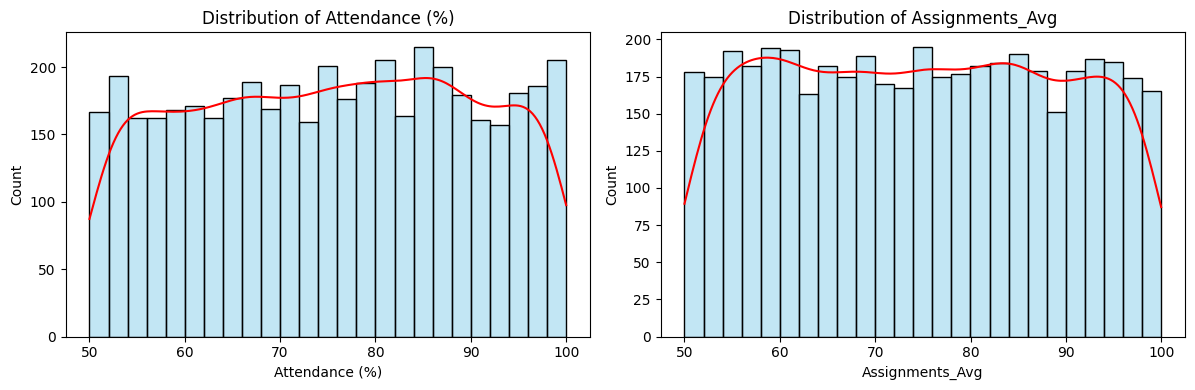

percentage and distribution plots.


In [29]:
numerical_cols = ['Attendance (%)','Assignments_Avg']
plot_histograms(df, numerical_cols)

print("percentage and distribution plots.")

The Assignments_Avg and Attendance columns show a relatively symmetric distribution, without significant skewness.
This symmetry is essential because it implies that randomly sampling existing (non-missing) data points are less likely to introduce bias.

With the mean and median we can streghen this assumption:

In [30]:
summary_df = df[['Assignments_Avg', 'Attendance (%)']].agg(['mean', 'median']).rename(index={'mean': 'Mean', 'median': 'Median'})
print(summary_df)

        Assignments_Avg  Attendance (%)
Mean          74.798673       75.431409
Median        74.810000       75.725000


> We confirmed that indeed they have a symmetric distribution, indicated by the close alignment between their means and medians.

Therefore we can also  that columns have relativily low variance, meaning the observed values are closely grouped together. With low variance, random sampling does not introduce extreme values or distortions, preserving the natural variability of the data.

##### B.2.1 Inputation Method of Random Sampling

In [31]:
df_random = df.copy()
df_original = df

columns_to_impute = ['Assignments_Avg', 'Attendance (%)']
df_random = apply_random_imputation(df_random, columns_to_impute)

print("Missing values after imputation:\n", df_random[['Assignments_Avg', 'Attendance (%)']].isnull().sum())

Missing values after imputation:
 Assignments_Avg    0
Attendance (%)     0
dtype: int64


##### B.2.3 Visual Confirmation and KS TEST

###### A. Attendance (%)

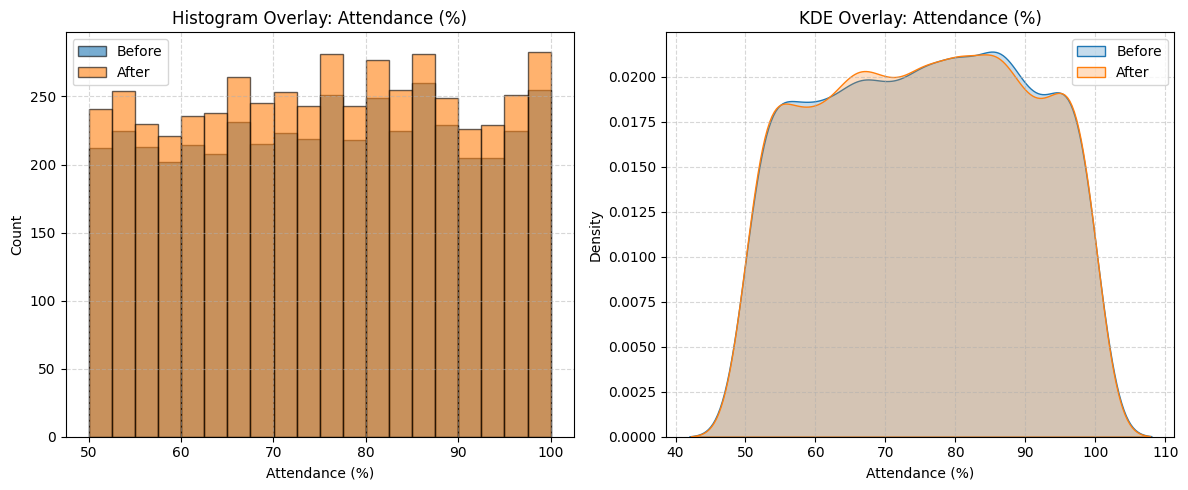

A Overlay of Before the Random Sampling Inputation Method and After
KS Test for Attendance (%): KS Statistic=0.0043, p-value=1.0000



In [32]:
plot_overlay_histogram_kde(df_original, df_random, 'Attendance (%)')
print("A Overlay of Before the Random Sampling Inputation Method and After")
# KS Test for 'Attendance (%)'
ks_test_imputation(df_original, df_random, 'Attendance (%)')

###### B. Assignments_Avg

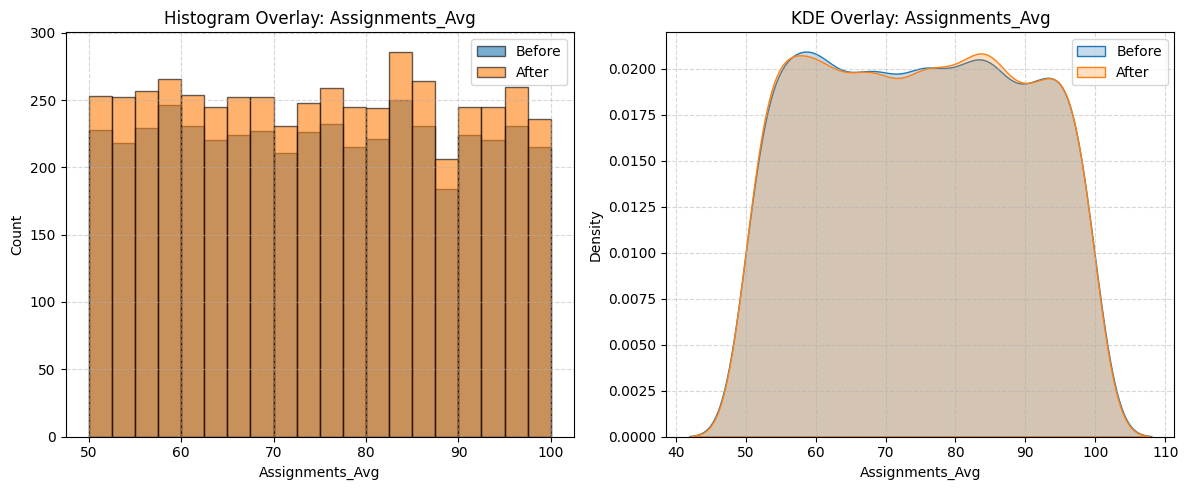

A Overlay of Before the Random Sampling Inputation Method and After
KS Test for Assignments_Avg: KS Statistic=0.0027, p-value=1.0000



In [33]:
plot_overlay_histogram_kde(df_original, df_random, 'Assignments_Avg')
print("A Overlay of Before the Random Sampling Inputation Method and After")
# KS Test for 'Assignments_Avg'
ks_test_imputation(df_original, df_random, 'Assignments_Avg')

In [34]:
# apply the changes to our main flow
df = df_random

##### B.2.5 Conclusion

With the Visual Overlaw and use of the **Kolmogorov-Smirnov (KS) test**, we are certain that:

> **Our imputation has not altered the underlying distributions of these variables, which is a positive outcome for preserving data integrity during the imputation process.**

**What is the KS test?** \
In simpler terms:

**1\. KS Statistic:** Indicates if the distributions are similar.  
- **Lower = Better**
  - 0.00 - 0.05: **Excellent match 
  **
  - 0.05 - 0.10: **Good match ✔️**
  - 0.10 - 0.20: Medium difference ⚠️
  - 0.20 - 0.30: Poor match ❌
  - 0.30: Very poor match 🚩

**2\. P-value:** How statistically significant is the difference between the distributions before and after imputation.  
- **Lower = Worse**
  - value < 0.05: Really bad ❌ (significant difference)
  - value ≥ 0.05: Good ✅ (no significant difference)

**Thus:**  
- Attendance (%): **KS Statistic = 0.0043**  
- Assignments_Avg: **KS Statistic = 0.0027**

Both statistics show a **very small difference and an excellent match**.

Additionally, a **p-value equal to 1** is very strong evidence that **no statistically significant difference** is present.

### C. Range

Check if everthing is in range.

In [35]:
# validate Range Score of Numerical Columns and Grades
validate_data(df)

 ✅ Success - Not found element out of range  ✔


### D. Duplicate Unique values

Duplicate values in fields that should be unique, can break the integrity of our data. \
In this dataset, two columns stand out:

- Student_ID
- Email

That cannot be duplicated, therefore must be checked.


#### D.0 Checker Student_ID And Email

In [36]:
columns=['Student_ID', 'Email']

check_duplicates(df, columns)

Student_ID:  ✅ Success - No Duplicated Elements.

Email:  ✅ Success - No Duplicated Elements.



### E. Outlier in Numerical Columns 

A simple checker for outliers in our numerical data.

In [37]:
numeric_columns = df.select_dtypes(include=['number']).columns

In [38]:
detect_outliers_IQR(df, numeric_columns)

 ✅ No outliers in column: Age
 ✅ No outliers in column: Attendance (%)
 ✅ No outliers in column: Midterm_Score
 ✅ No outliers in column: Final_Score
 ✅ No outliers in column: Assignments_Avg
 ✅ No outliers in column: Quizzes_Avg
 ✅ No outliers in column: Participation_Score
 ✅ No outliers in column: Projects_Score
 ✅ No outliers in column: Total_Score
 ✅ No outliers in column: Study_Hours_per_Week
 ✅ No outliers in column: Stress_Level (1-10)
 ✅ No outliers in column: Sleep_Hours_per_Night


### F. Saving Cleaned Data

In [39]:
save_dataframe(df, '../data/processed', 'student_performance_cleaned_V3.csv')

 ✅ Success - DataFrame saved at: ../data/processed/student_performance_cleaned_V3.csv ✔


# 📑 B. Initial Look

## 📑 b. Organize the data

We can segragate the data in some unique groups:

#### 1. Unique indicators

##### 🆔 Identification and Personal Information  
<table>
    <tr>
        <th>Indicator</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Student_ID</td>
        <td>Unique identifier for each student</td>
    </tr>
    <tr>
        <td>First_Name</td>
        <td>Student’s first name</td>
    </tr>
    <tr>
        <td>Last_Name</td>
        <td>Student’s last name</td>
    </tr>
    <tr>
        <td>Email</td>
        <td>Contact email</td>
    </tr>
</table>

#### 2. Main Score Indicators

##### 🔍 Direct Assessment Scores
<table>
    <tr>
        <th>Indicator</th>
        <th>Range</th>
    </tr>
    <tr>
        <td>Projects_Score</td>
        <td>0–100</td>
    </tr>
    <tr>
        <td>Midterm_Score</td>
        <td>0–100</td>
    </tr>
    <tr>
        <td>Final_Score</td>
        <td>0–100</td>
    </tr>
    <tr>
        <td>Assignments_Avg</td>
        <td>0–100</td>
    </tr>
    <tr>
        <td>Quizzes_Avg</td>
        <td>0–100</td>
    </tr>
</table>

##### 📊 Aggregated Measures  
<table>
    <tr>
        <th>Indicator</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Total_Score</td>
        <td>Weighted sum of all grades</td>
    </tr>
    <tr>
        <td>Grade</td>
        <td>Letter grade (A, B, C, D, F)</td>
    </tr>
</table>

#### 3. Secondary Indicators

##### 📚 Academic Engagement  

<table>
    <tr>
        <th>Indicator</th>
        <th>Range</th>
    </tr>
        <tr>
        <td>Participation_Score</td>
        <td>0–10</td>
    </tr>
    <tr>
        <td>Attendance (%)</td>
        <td>0–100%</td>
    </tr>
</table>

##### 🌍 Demographics and Academic Program  
<table>
    <tr>
        <th>Indicator</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Gender</td>
        <td>Male, Female, Other</td>
    </tr>
    <tr>
        <td>Age</td>
        <td>The age of the student</td>
    </tr>
    <tr>
        <td>Department</td>
        <td>Student's department</td>
    </tr>
</table>

##### 📖 Study Habits and Environment  
<table>
    <tr>
        <th>Indicator</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Study_Hours_per_Week</td>
        <td>Average study hours per week</td>
    </tr>
        <tr>
        <td>Internet_Access_at_Home</td>
        <td>Has internet access at home? (Yes/No)</td>
    </tr>
    <tr>
        <td>Extracurricular_Activities</td>
        <td>Participates in extracurriculars? (Yes/No)</td>
    </tr>
</table>

##### 🏡 Socioeconomic and Family Background  
<table>
    <tr>
        <th>Indicator</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Parent_Education_Level</td>
        <td>Highest education level of parents (None, High School, Bachelor's, Master's, PhD)</td>
    </tr>
    <tr>
        <td>Family_Income_Level</td>
        <td>Low, Medium, High</td>
    </tr>
</table>

##### 💡 Well-Being and Lifestyle Factors  
<table>
    <tr>
        <th>Indicator</th>
        <th>Range</th>
    </tr>
    <tr>
        <td>Stress_Level</td>
        <td>1–10 (Self-reported stress level, 1: Low, 10: High)</td>
    </tr>
    <tr>
        <td>Sleep_Hours_per_Night</td>
        <td>Average hours of sleep per night</td>
    </tr>
</table>

## 🔍 Descriptive Statistics


>For a clearer analysis, I will further separate the data into Numerical and Categorical

### 2.A Univariate Numerical Data

#### 2.A.0 Age

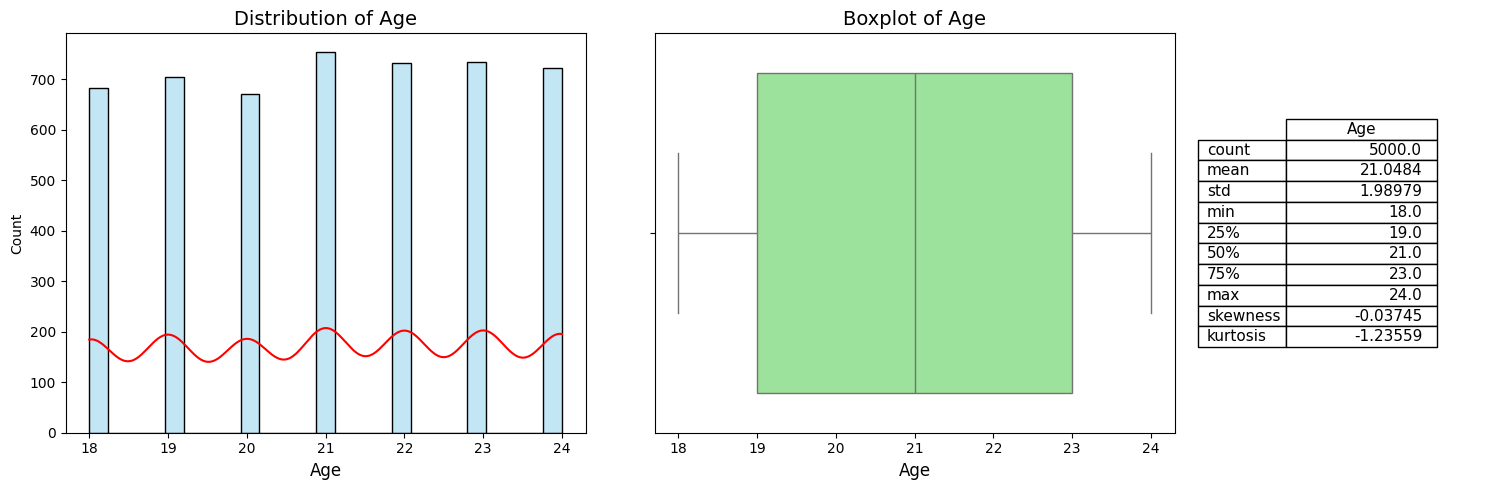

In [40]:
explore_variable(df, 'Age')

Key Finding: We have Ages range 18–24 with distinct peaks rather than a smooth spread.

> Interpretation: The student population is young and a specifc age group, young.

#### 2.A.1 Direct Assessment Scores

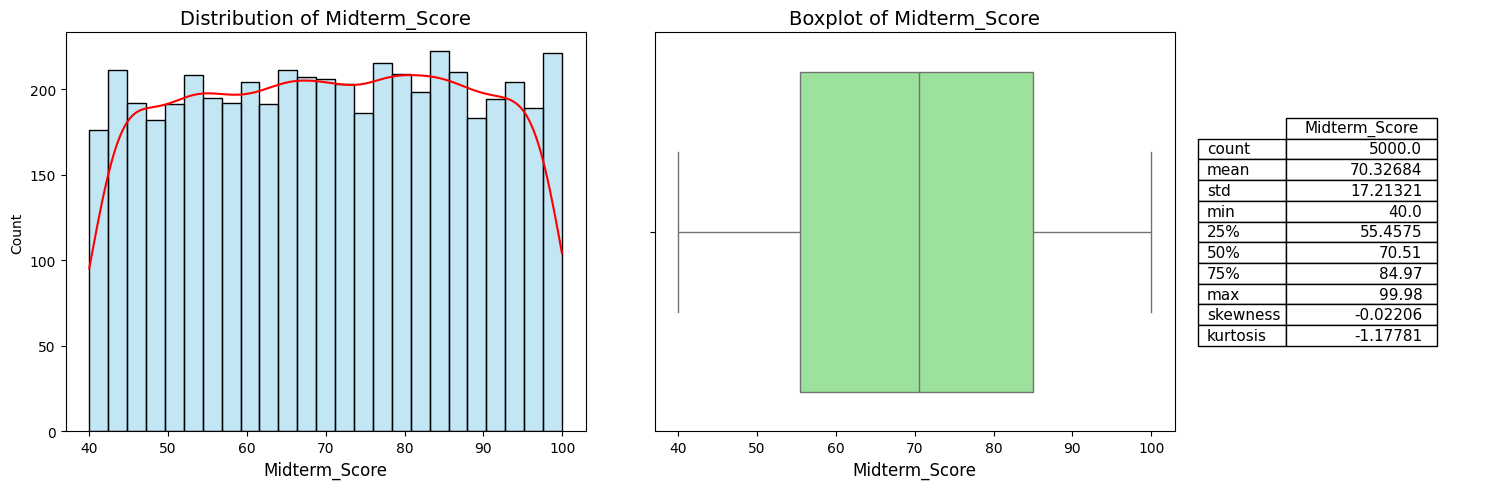

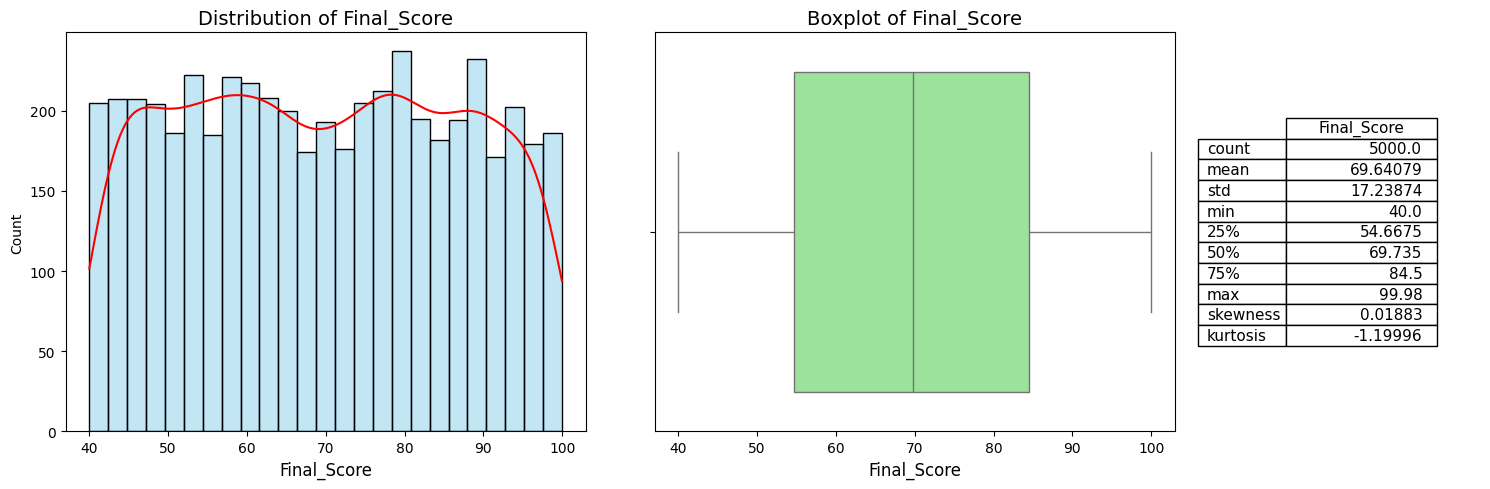

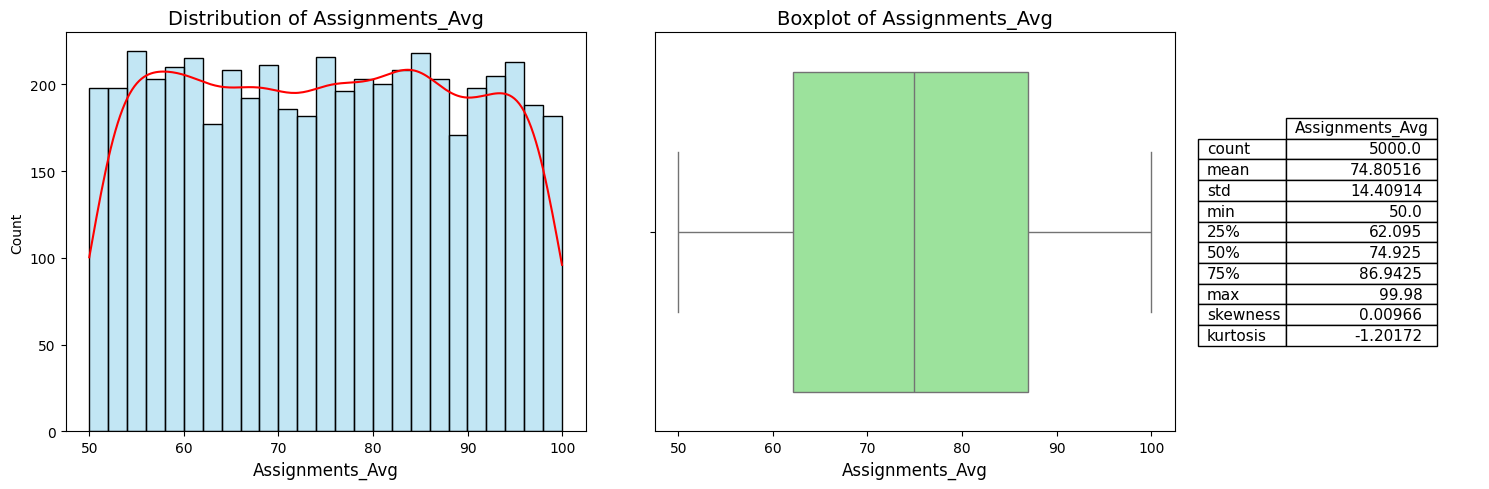

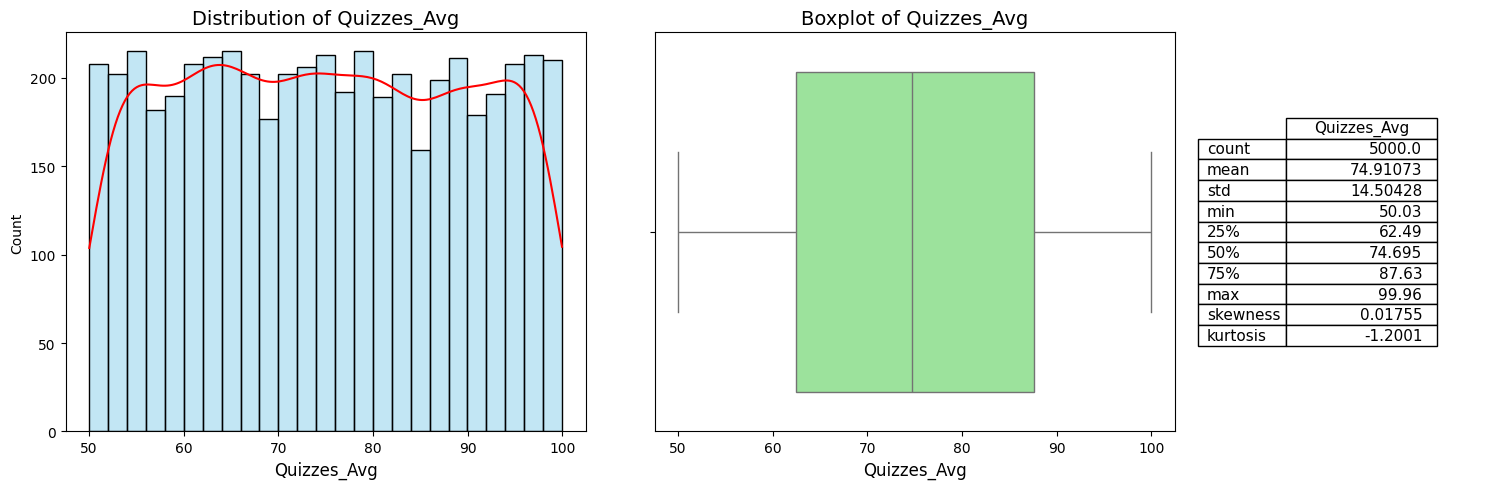

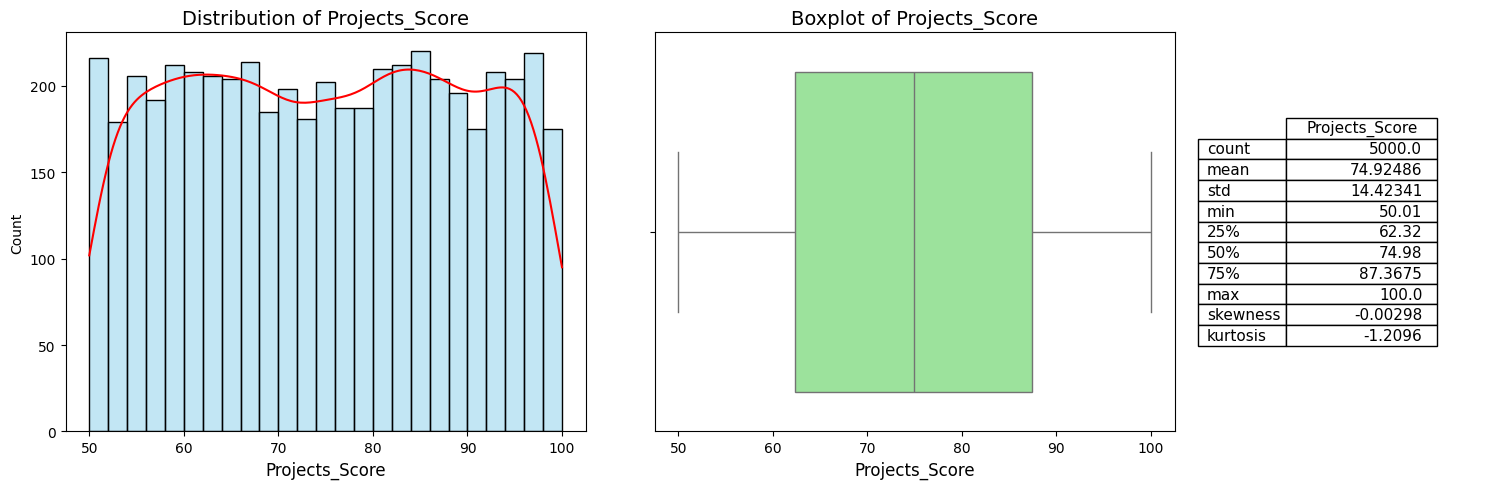

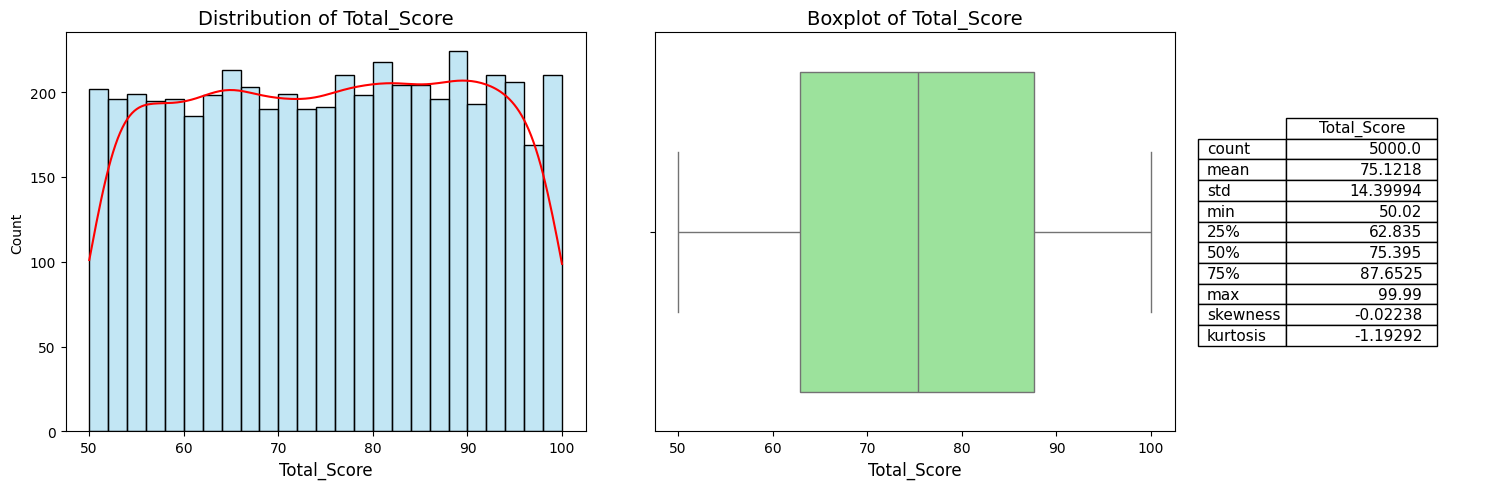

In [41]:
explore_all_numerical_variables(df, ('Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Projects_Score', 'Total_Score'))

Scores (Midterm, Final, Assignments, Quizzes, Total)

Key Finding: Range 50–100, no one scoring <40 in any category!
Even distribution (not bell-shaped), with negative kurtosis (~-1.2) indicating fewer extreme highs or lows.

Interpretation: Students’ performance is spread out between 50 and 100, but in a flattened pattern rather than clustering around a mean.
So i will be a good idea do cluster them to better undestand each one, also a similarity of 50-100 fall in the ~A B C D E F, of grades.
I think will be a good idea to convert them at some point and check their relationships.

#### 2.A.2 Participation

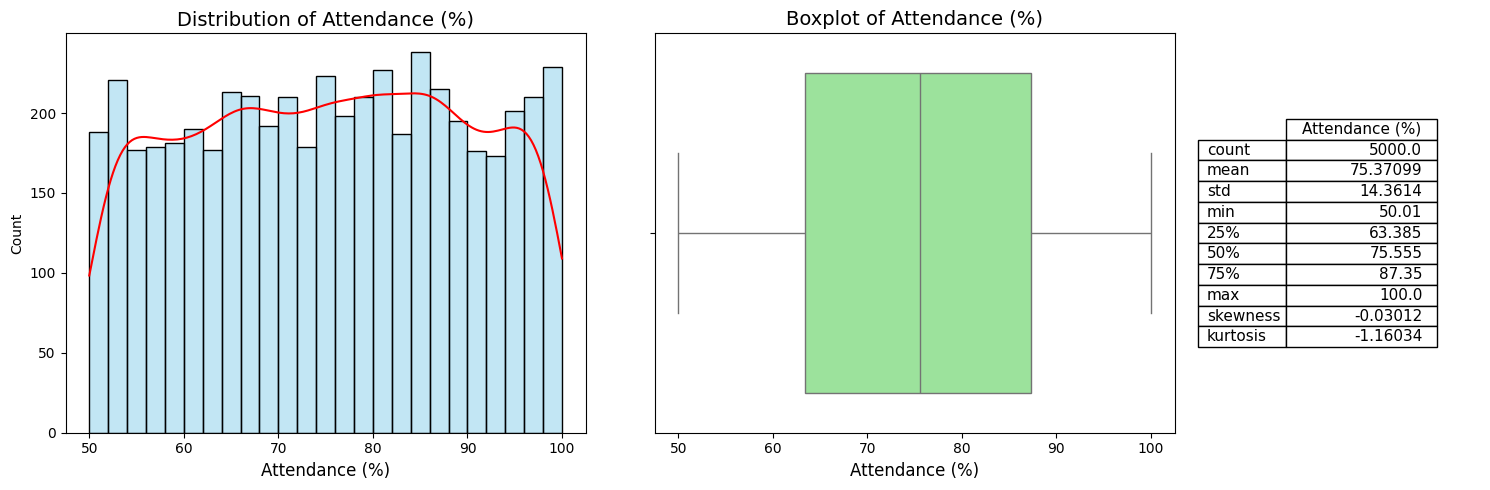

In [42]:
explore_variable(df, 'Attendance (%)')

Key Finding: Median ~75.55%, generally high attendance.

Interpretation: Most students attend regularly, which could be a positive indicator of engagement—though some have lower attendance that may warrant attention.

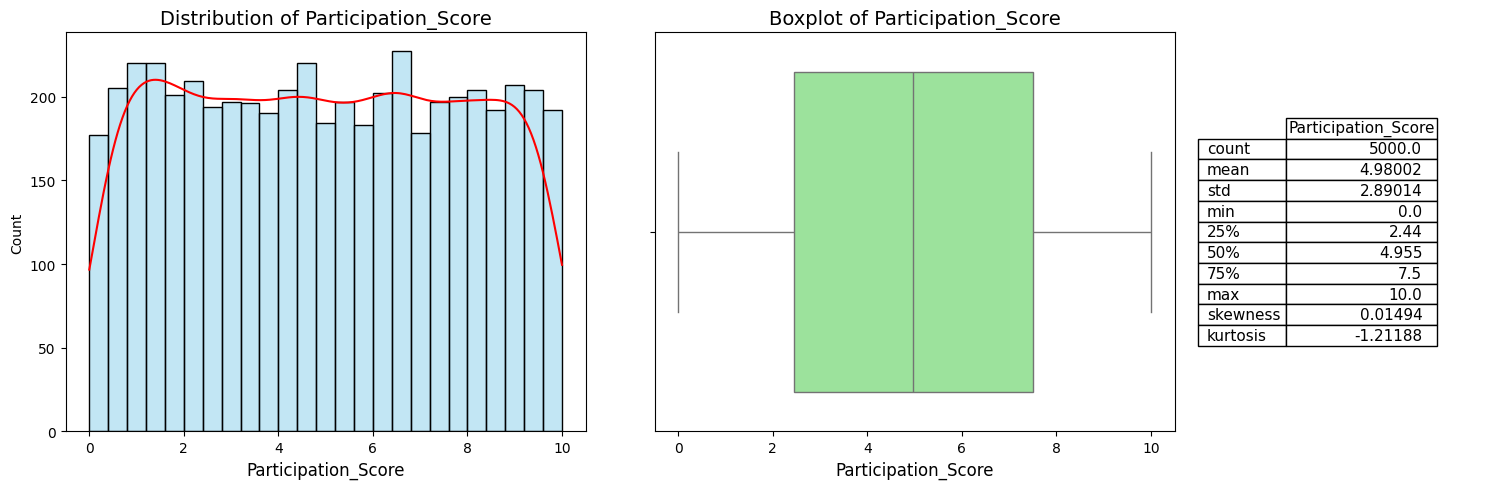

In [43]:
explore_variable(df, 'Participation_Score')

Key Finding: Mean ≈ 4.98, median ≈ 4.95, showing an even distribution without clear peaks or dips.

Interpretation: Students participate at moderate levels on average; no large group dominates at either high or low participation extremes.

#### 2.A.3 Attendance (%)

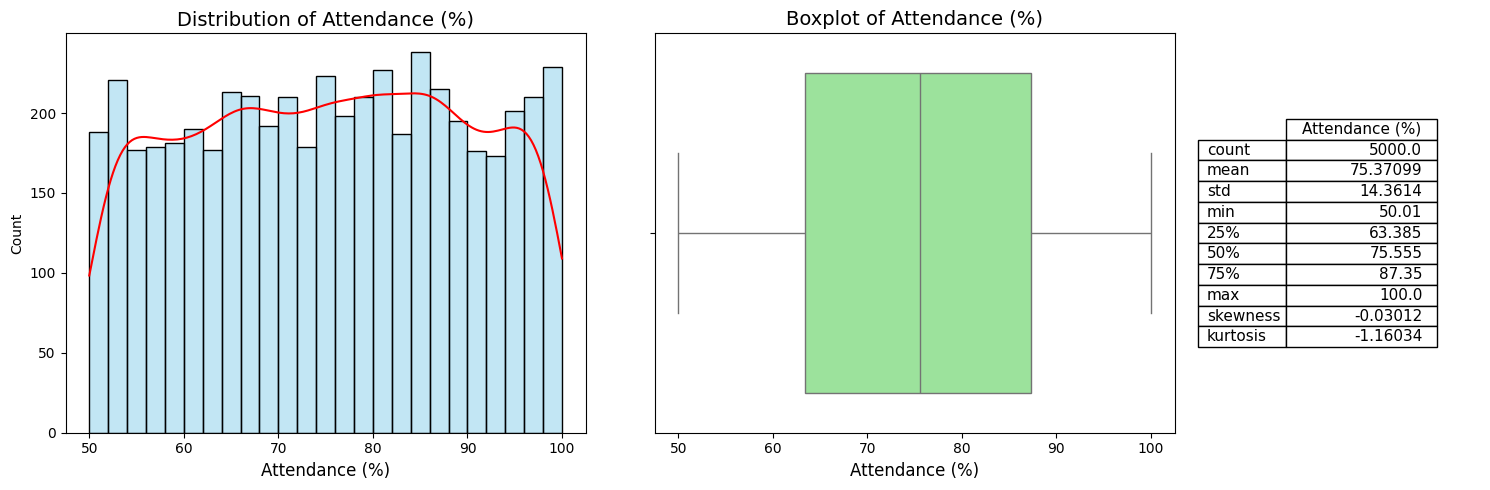

In [44]:
explore_variable(df, 'Attendance (%)')

Key Finding: Median ~75.55%, generally high attendance.

- Interpretation: Most students attend regularly, which could be a positive indicator of engagement—though some have lower attendance that may warrant attention

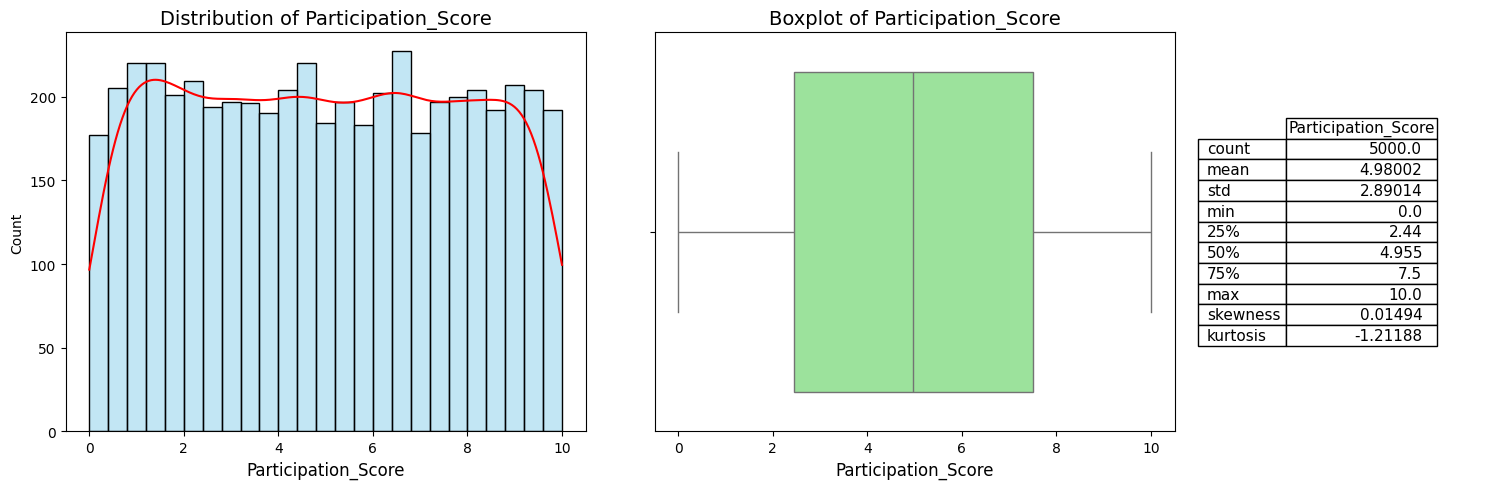

In [45]:
explore_variable(df, 'Participation_Score')

Participation Score
Key Finding: Mean ≈ 4.98, median ≈ 4.95, showing an even distribution without clear peaks or dips.

Interpretation: Students participate at moderate levels on average; no large group dominates at either high or low participation extremes.

#### 2.A.4 Habits

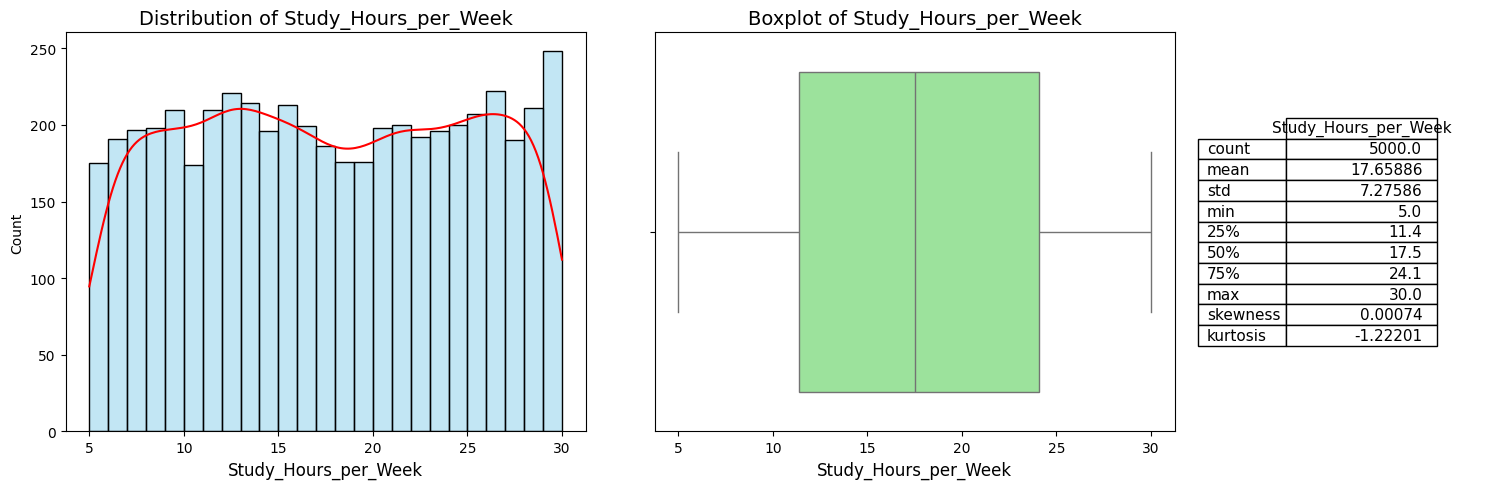

In [46]:
explore_variable(df, 'Study_Hours_per_Week')

Key Finding: Wide IQR (~11.4 to 24.1 hours) and non-normal distribution.

Interpretation: Study habits vary significantly, suggesting diverse approaches (some study a few hours, others well above average).

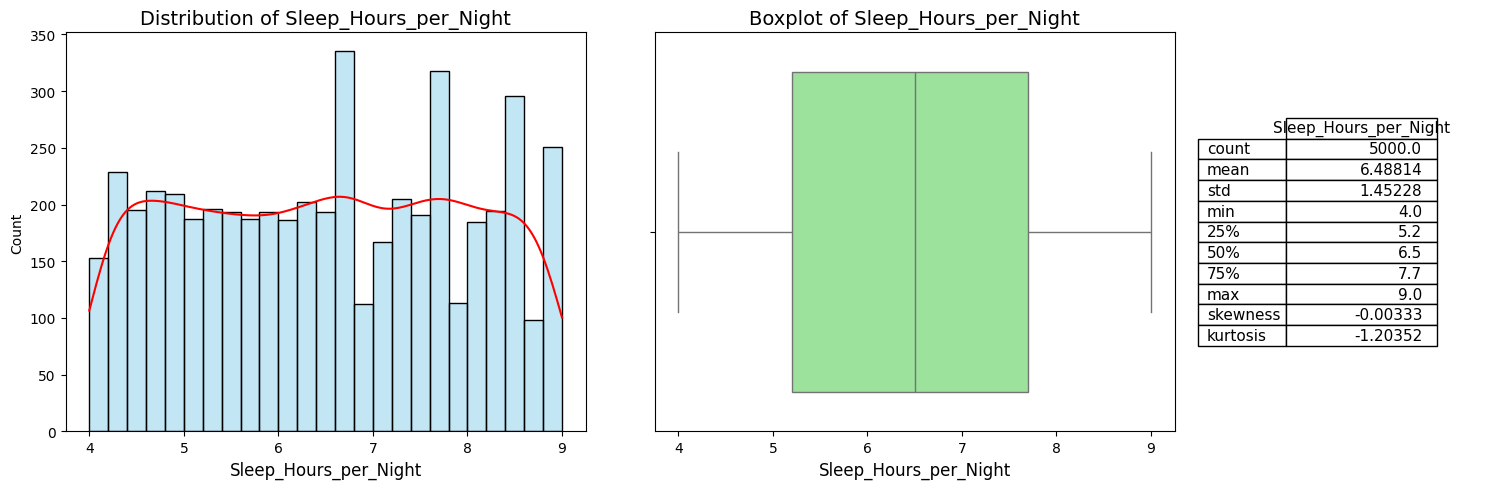

In [47]:
explore_variable(df, 'Sleep_Hours_per_Night')

Key Finding: Flat distribution (negative kurtosis), values between ~4 and 9 hours, no single peak.

Interpretation: Students have varied sleep routines, with most falling in the 5–8 hour range but not clustering around a single norm.

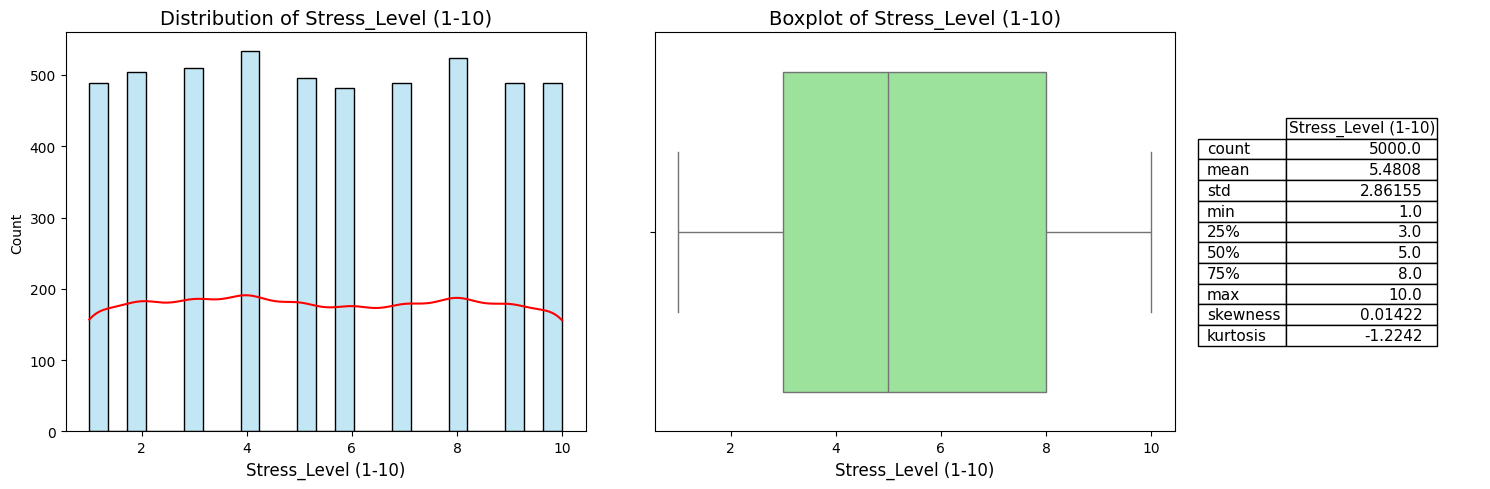

In [48]:
explore_variable(df,  'Stress_Level (1-10)')

Key Finding: Peaks around 2, 5, and 7; fewer at the extremes (1, 10).

Interpretation: Most students report moderate stress, though a subset experiences low (2) or moderate-to-high (7) levels.

### 2.B Univariate Categorical Data

#### 2.B.0  Demographics and Academic Program¶

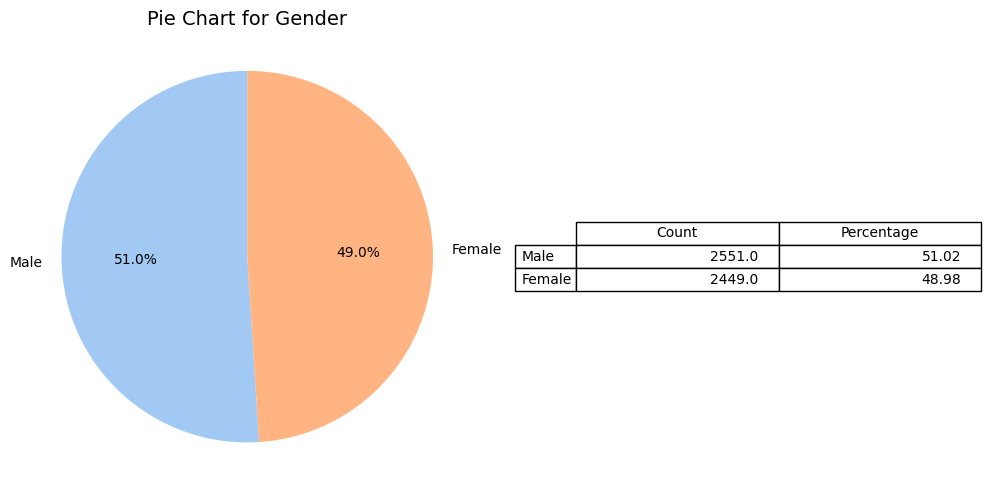

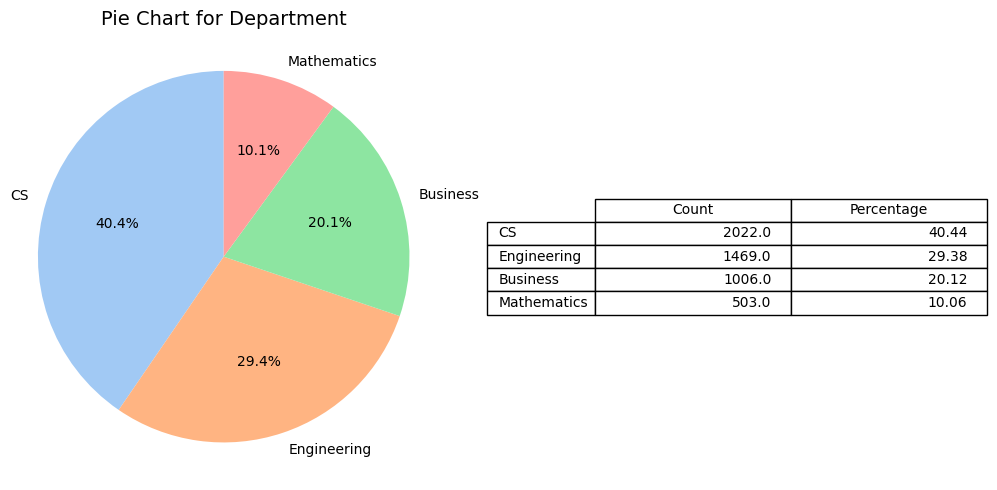

In [51]:
explore_all_categorical_variables(df,['Gender', 'Department'])

> We have a nearly a 50/50 Gender split!  well-balanced. 

> CS is the largest and Mathematics has the least students

Interpretation: Results may lean toward insights specific to CS! or Engineering.
So smaller departments may need careful handling to avoid sample-size issues.

#### 2.B.1 Study Habits and Environment

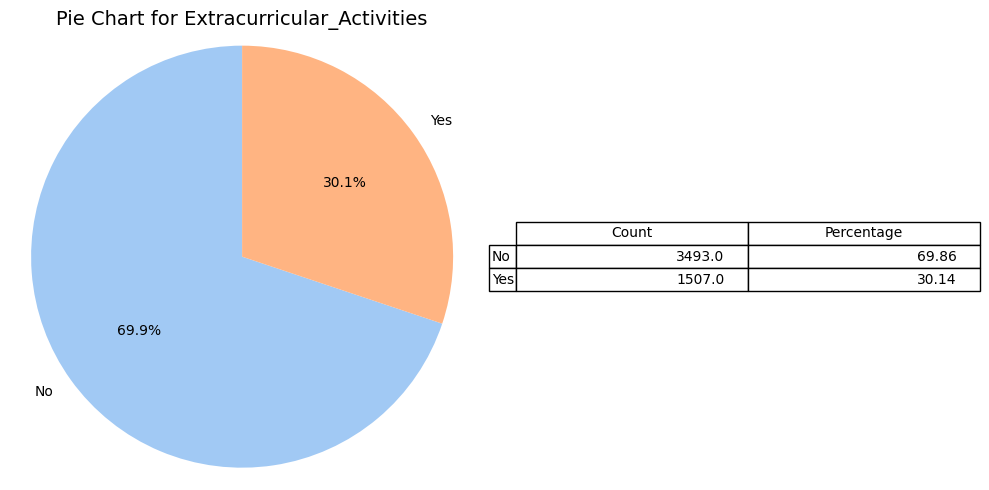

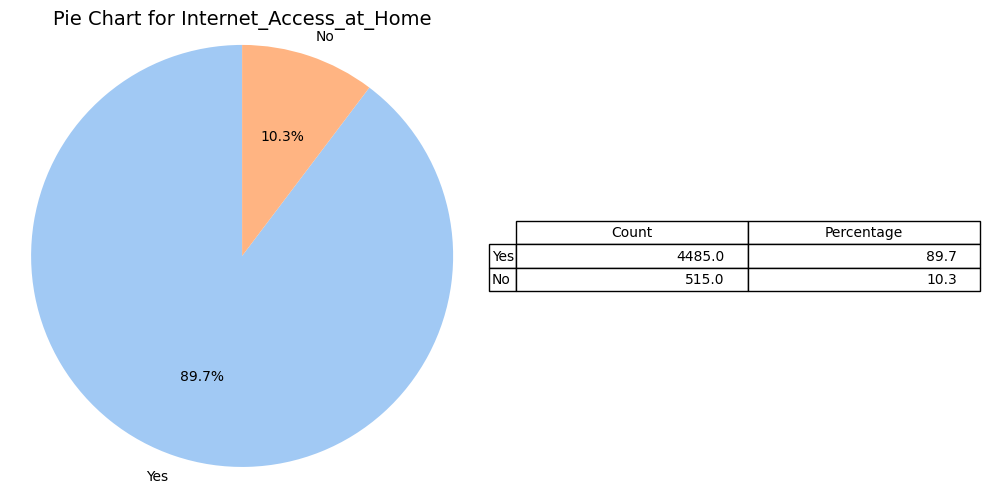

In [52]:
explore_all_categorical_variables(df,['Extracurricular_Activities', 'Internet_Access_at_Home'])

Most do students do not engage in extracurriculars so it could be a factor if exploring how involvement affects performance...
and Nearly all have home internet, so we need to be aware of the bias toward the results.

#### 2.B.1  Socioeconomic and Family Background  

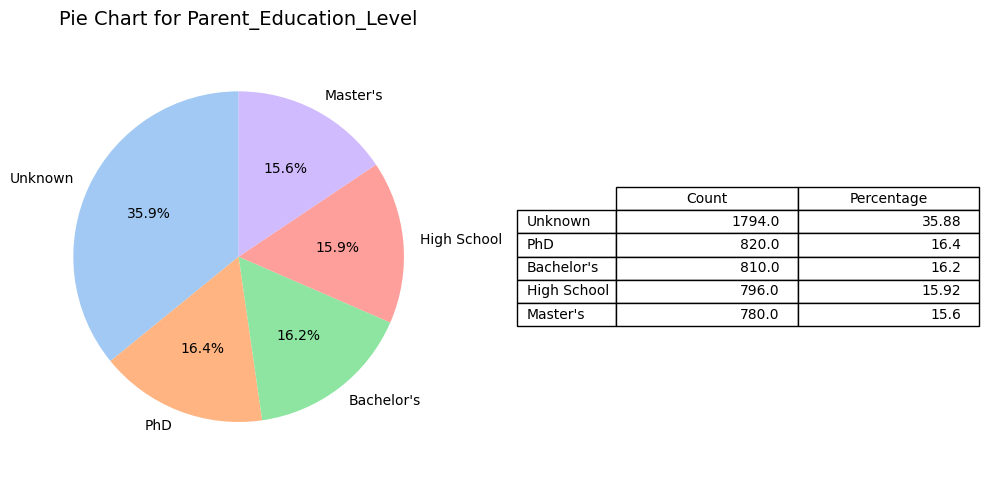

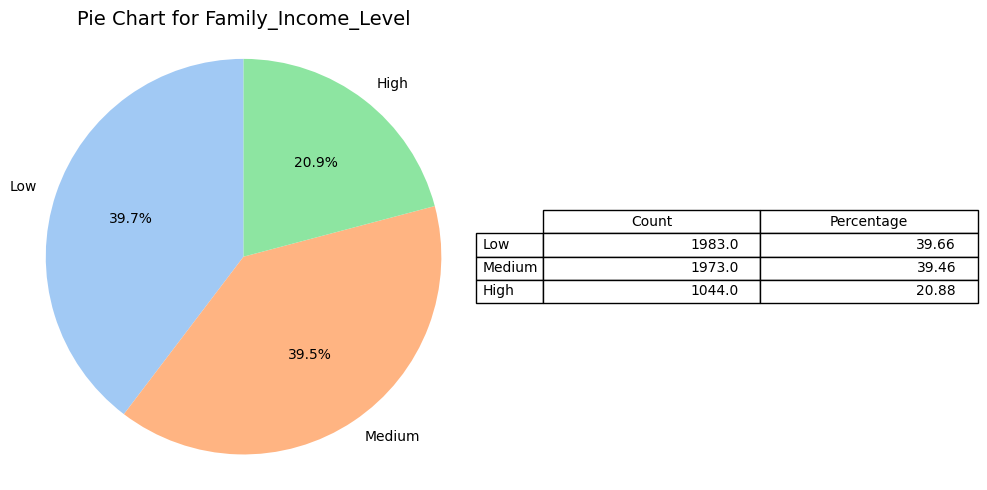

In [53]:
explore_all_categorical_variables(df,['Parent_Education_Level', 'Family_Income_Level'])

Interpretation:
If we ignore the big part of our missing data (35.88% “Unknown) we have a near-even split among PhD, Bachelor’s, High School, and Master’s. 

In Family Income we have a majority (~80%) in Low–Medium brackets

#### 2.B.3 Grade

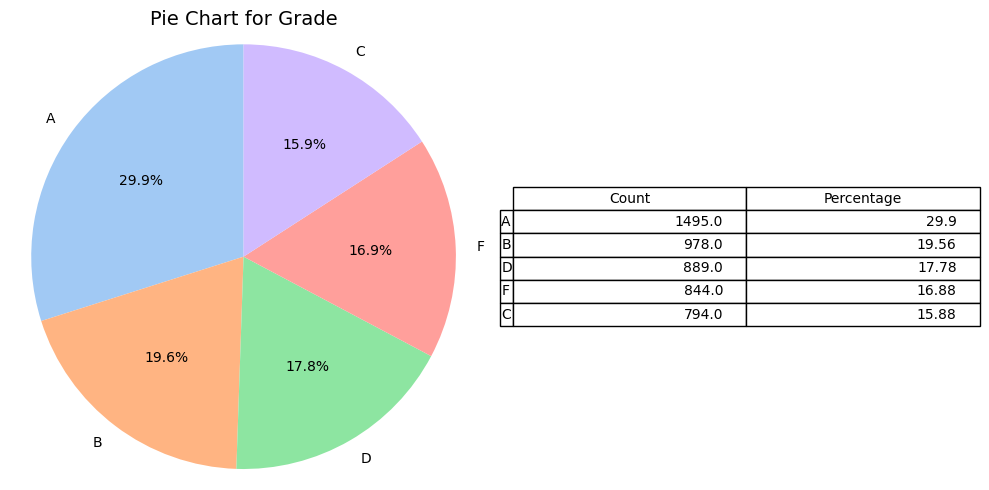

In [54]:
explore_categorical_variable(df, 'Grade')

Interpretation: A is the most common, half of students are in A/B range! they are good students.

### 3. Multivariate Analysis

To start our analysis, we will use some correlation methods.

Since the data shows uniform distributions and lacks normality, we will apply non-parametric correlation methods. These methods do not assume any specific distribution, making them ideal, 

> unlike parametric methods such as Pearson’s correlation that relies on linear and normally distributed data

The two methods we'll use are:

1. Kendall’s Tau

> Measures how consistently the rankings of pairs of data agree or disagree.

Is ideal for ordinal or ranked data.

2. Spearman’s Rho

>Captures monotonic relationships, where variables move in the same or opposite direction, even if the relationship is not linear!

help us understand, if one variable tend to increase or decrease as the other does...

When looking at correlations we expect:

| Correlation strength | Value Range |
|----------------------|-------------|
| Weak                 | 0.0–0.3     |
| Moderate             | 0.3–0.5     |
| Strong               | 0.5–0.8     |
| Very Strong          | 0.8–1.0     |



### 4. Variables Correlation 

Lets convert the most significant ones for our analysis, such as grade, income, internet access and
extracurricular Activities, those can be converted in ~ranks, so we can have a deeper understanding of the data.

In [55]:
# setting up the map convertion
internet_and_activity_map = {'No': 0, 'Yes': 1}
income_map = {'Low': 0, 'Medium': 1, 'High': 3}
grade_map = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}

In [56]:
# mapping it and creating new columns
df['Extracurricular_Activities_Ranked'] = df['Extracurricular_Activities'].map(internet_and_activity_map)
df['Internet_Access_at_Home_Ranked'] = df['Internet_Access_at_Home'].map(internet_and_activity_map)
df['Family_Income_Level_Ranked'] = df['Family_Income_Level'].map(income_map)
df['Grade_Ranked'] = df['Grade'].map(grade_map)

In [57]:
# ensure that we take only numerical columns !
numerical_cols = df.select_dtypes(include=['number']).columns

In [58]:
# Get Corelation Matrix of the data
corr_spearman, corr_kendall = compute_correlation_matrices(df, numerical_cols)

In [59]:
# rename for better visual compreension
corr_kendall = rename_matrix(corr_kendall)
corr_spearman = rename_matrix(corr_spearman)

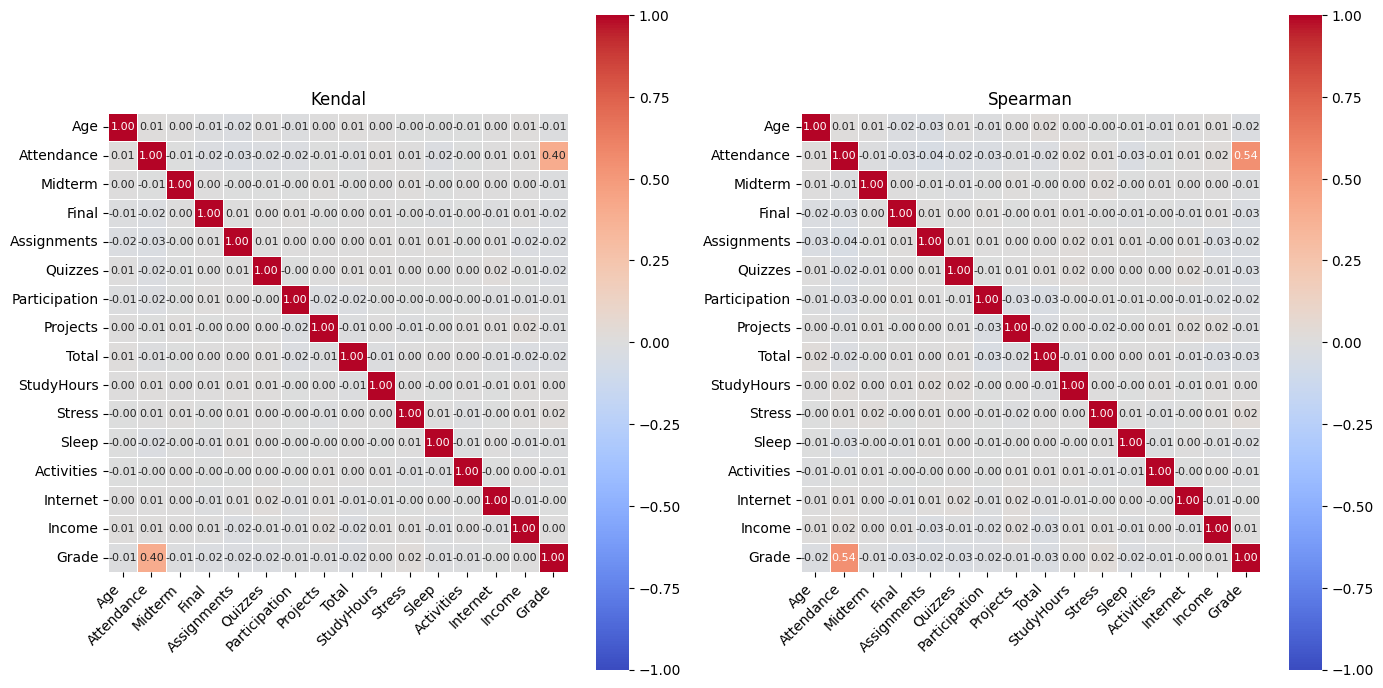

In [60]:
plot_multiple_heatmaps([corr_kendall, corr_spearman], titles=["Kendal", "Spearman"])

- Overall Summary:

#### **What can help us understand academic performance?**

1. **Grade** and **Attendance**, showing a moderately strong positive correlation of approximately **+0.40**.
    > hypothesis (H1): as attendance increases, so do final grades. 

All other pairwise correlations are notably smaller! suggesting very weak or practically negligible relationships. 

While these associations appear minor in a broad view, they still can provide insights, it could be the result of the low variation of our data, so we need to go deeper.

2.  **Attendance** and  **Sleep**, show a minor negative correlation 
    > hypothesis (H1): Could indicate that students that have higher attendance frequency tend to sleep less

3.  **Grade** and  **Stress**, show a minor correlation with the total and stress
    > hypothesis (H1): as stress  increases, so do final grades.

4. **Total_Score** and **Participation_Score**, minor negative correlation
    > hypothesis (H1): Participation could reduce your total scpre

5. **Total_score**  and  **Grade**, minor negative correlation
    > hypothesis (H1): high scores can affect negativly others aspects, and therefore the final gtade 

### 3. Deeper Look in Agragated Data

#### 3.A Grade 

What is grade, my first assumption is the American grading system, where it is the final letter evaluation assigned to each student.

Typically, it should behave with the total_Score, where higher numerical scores normally correspond to a better better grade.

- A 90–100% 
- B 80–89%
- C 70–79%
- D 60–69
- F 0–59%
 
So we need to confirm it.

In [61]:
# total score to grade mapping (A >= 90, ...,  F > 60)
df['computed_grade'] = df['Total_Score'].apply(compute_grade)

In [62]:
# let's compare the original grade with the computed grade
df['match'] = df['Grade'] == df['computed_grade']
grade_match_percentage = df.groupby('Grade')['match'].mean() * 100
print("\nMatch percentage by grade:")
print(grade_match_percentage)


Match percentage by grade:
Grade
A    17.792642
B    19.427403
C    16.624685
D    20.247469
F    22.393365
Name: match, dtype: float64


The findings indicate that only a small percentage of the actual grade and the expected in each grade category match!

Grade is meant to be derived from the Total_Score, mapping numerical values into letter categories (A, B, C, D, F).
The expected relationship in the boxplot (higher scores mean better grades) is clearly, not evident.

> Grade do no match the total_score

which raises questions about how the transformation is defined or applied.

### Total_Score

Since Total_Score is described as a weighted sum of all grades, it’s likely a single numeric measure that incorporates midterm, final, assignments, quizzes, projects, and possibly participation, but it was not what we found out!

Expected Linear Relationships
When you expect a Total_Score to be a weighted sum of other grades. (like midterm, final, assignments, etc.)
We anticipate that the Total_Score would show strong linear relationships!!! with those component scores.
It should have been evident In this Pearson correlation matrix, this means you’d expect correlation coefficients close to 1 (or -1, if negatively weighted) between the Total_Score and its components.

But is not what we see here, we have a near-zero linear correlation!
In summary, a near-zero linear correlation suggests that, despite the Total_Score being defined as a weighted sum, the relationship between it and its individual components does not follow a simple linear pattern or that the data might be processed in a way that obscures these linear relationships.

Risks of Non-Transparency
The lack of transparency in the calculation method risks basing our analysis on a score that might overlook or misrepresent important aspects of performance. leading to an incomplete view.

# 🔍 B. Overview

#### 🎯 1. Total Score Isn’t reliable
We expected `Total_Score` to be strongly correlated with its components (`Midterm`, `Final`, `Assignments`), but the correlation is near zero.

If `Total_Score` is based on hidden or inconsistent calculations, it loses meaning:

- Without transparency, it becomes hard to interpret or compare.

- This suggests issues with how `Total_Score` is calculated... could involve an unknown formula or transformation.
- Without clarity or consistency, it can't be really trusted as an accurate measure of performance.

#### 🧮 2. Letter Grades Don’t Align with Scores

Letter grades (`A`, `B`, `C`, etc.) should logically follow from `Total_Score`, but that pattern isn’t clear in the data.

- Students with high scores don’t always get high grades.
- This points to possible misclassification or unclear grading system.


## 🚩 **So we will be using `Grade` as academic performance**

>In conclusion, the total score lacks transparency and consistency, showing little correlation with its component scores and yielding letter grades that don’t align with expected patterns. Because of this uncertainty, we will rely on the letter grade as a more reliable indicator of academic performance.

#### ☢️ 3. Flat, Uniform Distributions Make Analysis Harder

Many variables are **evenly distributed**, with no strong central!
- This makes it hard to identify dominant groups or typical behaviors.
- Weak correlations may be a result of this uniformity rather than a true lack of relationship.


### 📊 4. Demographics Overview

- **Gender**: Balanced.
- **Departments**: Dominated by CS students.
- **Parental Education & Income**: Vary widely, with many "Unknown" entries.


### 🔍 Next Steps 

Besides the **Grade** and **Attendance** high correlation
We need to explore the most evident correlations of the matrix, even if they are small, it could lead to clues, as:
   - **Attendance** and  **Sleep**,
   - **Grade** and  **Stress**
   - **Total_Score** and **Participation_Score**
   - **Total_score**  and  **Grade**

### 🧩 A Challenge: Uniformity in Data
 
> Many variables have flat, uniform distributions rather than bell curves.

#### `Implications`
> Weak correlations may be due to the lack of dominant trends, so group analysis may perform better.


# 🪢 C. Data Engineering

## C.0 Load and Check

In [63]:
source = "../../data/processed/student_performance_cleaned_V3.csv"
dataBase = pd.read_csv(source)
df = dataBase.copy()

In [64]:
# # We make a Basic check to see if what we have, is what we expect. (columns)
check_required_columns(df)

✅ All required columns are present.


## C.1 Name Standardization

### C.1.0 Clean Names

We want consistent, easy names to avoid the struggle as in the planning. 
- Remove any whitespace.
- Convert to lower case 
- Replace spaces with underscores
- Fix wierd names

In [65]:
df = clean_columns_names(df)
print(df.columns)

Index(['student_id', 'first_name', 'last_name', 'email', 'gender', 'age',
       'department', 'attendance', 'midterm_score', 'final_score',
       'assignments_avg', 'quizzes_avg', 'participation_score',
       'projects_score', 'total_score', 'grade', 'study_hours_per_week',
       'extracurricular_activities', 'internet_access_at_home',
       'parent_education_level', 'family_income_level', 'stress_level',
       'sleep_hours_per_night'],
      dtype='object')


> ✅ We removed wierd naming and made them all padronized

### C.1.1 Unused Columns

We remove the identification columns:
1. Student_Id
2. First_Name
3. Last_Name
4. Email

Since they won`t be needed for analysis and might contain personal information.

In [66]:
columns_to_remove = ['student_id', 'first_name', 'last_name', 'email']
df.drop(columns=columns_to_remove, inplace=True)

print("\nColumns after removal:")
print(df.columns)


Columns after removal:
Index(['gender', 'age', 'department', 'attendance', 'midterm_score',
       'final_score', 'assignments_avg', 'quizzes_avg', 'participation_score',
       'projects_score', 'total_score', 'grade', 'study_hours_per_week',
       'extracurricular_activities', 'internet_access_at_home',
       'parent_education_level', 'family_income_level', 'stress_level',
       'sleep_hours_per_night'],
      dtype='object')


✅ Removed irrelevant and privacy sensitive data

### C.1.2 Categorical data to numeric

In [67]:
# relationship mapping for the composite variables
internet_and_activity_map = {'No': 0, 'Yes': 1}
income_map = {'Low': 0, 'Medium': 1, 'High': 3}
grade_map = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'F': 1}

In [68]:
# apply changes
df['extracurricular_activities'] = df['extracurricular_activities'].map(internet_and_activity_map)
df['internet_access_at_home'] = df['internet_access_at_home'].map(internet_and_activity_map)
df['grade'] = df['grade'].map(grade_map)

> ✅ Changed categorical data to  ML and other analysis methods

### C.1.3 Check data

In [69]:
df.head(1)

,gender,age,department,attendance,midterm_score,final_score,assignments_avg,quizzes_avg,participation_score,projects_score,total_score,grade,study_hours_per_week,extracurricular_activities,internet_access_at_home,parent_education_level,family_income_level,stress_level,sleep_hours_per_night
0,Female,22,Engineering,52.29,55.03,57.82,84.22,74.06,3.99,85.9,56.09,1,6.2,0,1,High School,Medium,5,4.7


In [70]:
df.shape

(5000, 19)

> ✅ Data as expected.

### C.2 Basic Feature Engineering

#### C.2.0 Academic Performance Score

> Taken the most common aproach in American educational institutions, since Numerical Grade is a characteristic of them.

In [71]:
df['academic_performance'] = (
    0.3 * df['midterm_score'] +
    0.3 * df['final_score'] +
    0.15 * df['assignments_avg'] +
    0.15 * df['quizzes_avg'] +
    0.15 * df['projects_score']
)

> ✅ Replace total_score with a clearer formula

#### C.2.1  Engagement Score

In [72]:
def engineer_engagement(df):
    df['engagement'] = (df['participation_score'] * 10 + df['attendance']) / 2
    return df

> ✅ Reflects classroom engagement

#### C.2.2 Study Efficiency

In [73]:
# Normalize study hours to a 40-hour week scale
df['study_hours_norm'] = df['study_hours_per_week'] / 40

In [74]:
# Calculate efficiency as score per hour, we also avoid division by zero.
df['efficiency_ratio'] = df['total_score'] / df['study_hours_per_week'].replace(0, 1e-6)

> ✅ study_hours_norm -> Measures output per study time

> ✅ efficiency_ratio -> Normalized study time

### C.3 Final check

In [75]:
df.head(1)

,gender,age,department,attendance,midterm_score,final_score,assignments_avg,quizzes_avg,participation_score,projects_score,...,study_hours_per_week,extracurricular_activities,internet_access_at_home,parent_education_level,family_income_level,stress_level,sleep_hours_per_night,academic_performance,study_hours_norm,efficiency_ratio
0,Female,22,Engineering,52.29,55.03,57.82,84.22,74.06,3.99,85.9,...,6.2,0,1,High School,Medium,5,4.7,70.482,0.155,9.046774


In [76]:
df.describe()

,age,attendance,midterm_score,final_score,assignments_avg,quizzes_avg,participation_score,projects_score,total_score,grade,study_hours_per_week,extracurricular_activities,internet_access_at_home,stress_level,sleep_hours_per_night,academic_performance,study_hours_norm,efficiency_ratio
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,21.048400,75.370988,70.326844,69.640788,74.805162,74.910728,4.980024,74.924860,75.121804,3.27820,17.658860,0.301400,0.897000,5.48080,6.488140,75.686402,0.441472,5.336198
std,1.989786,14.361398,17.213209,17.238744,14.409141,14.504281,2.890136,14.423415,14.399941,1.47229,7.275864,0.458912,0.303989,2.86155,1.452283,8.238204,0.181897,3.140092
min,18.000000,50.010000,40.000000,40.000000,50.000000,50.030000,0.000000,50.010000,50.020000,1.00000,5.000000,0.000000,0.000000,1.00000,4.000000,49.803000,0.125000,1.710239
25%,19.000000,63.385000,55.457500,54.667500,62.095000,62.490000,2.440000,62.320000,62.835000,2.00000,11.400000,0.000000,1.000000,3.00000,5.200000,69.953625,0.285000,3.106922
50%,21.000000,75.555000,70.510000,69.735000,74.925000,74.695000,4.955000,74.980000,75.395000,3.00000,17.500000,0.000000,1.000000,5.00000,6.500000,75.809250,0.437500,4.270188
75%,23.000000,87.350000,84.970000,84.500000,86.942500,87.630000,7.500000,87.367500,87.652500,5.00000,24.100000,1.000000,1.000000,8.00000,7.700000,81.571500,0.602500,6.613290
max,24.000000,100.000000,99.980000,99.980000,99.980000,99.960000,10.000000,100.000000,99.990000,5.00000,30.000000,1.000000,1.000000,10.00000,9.000000,99.825000,0.750000,19.960000


> ✅  Ok

### C.4 Saving

In [77]:
save_dataframe(df, '../data/processed', 'student_performance_data_engineering_v2.csv')

 ✅ Success - DataFrame saved at: ../data/processed/student_performance_data_engineering_v2.csv ✔


# 🔍 C. Overview

1. **Data Cleaning**
- Standardized column names for consistency.
- Removed irrelevant columns (`student_id`, `first_name`, `last_name`, `email`).
- Mapped categorical variables to numerical values:
  - Grades (`A` → `4`, ..., `F` → `0`)
  - Income levels, extracurricular activity, and internet access

✅ Result: Dataset prepared for correlation analysis, modeling, and visualization.

2. **Feature Engineering**
Created new variables to better capture hidden patterns, relationships, and student traits:

| Feature | Description | Purpose |
|--------|-------------|---------|
| `academic_performance` | Weighted average of midterm, final, assignments, quizzes, projects | Replaces unreliable `total_score` |
| `engagement` | Combines participation and attendance | Quantifies classroom involvement |
| `efficiency_ratio` | `total_score` per hour of study | Identifies under-/over-performing students |
| `study_hours_norm` | Normalized study hours | Allows fair comparison |
| `stress_inverted` | Rescales stress (high = good) | Used in well-being score |
| `sleep_norm` | Normalized sleep hours | Reflects lifestyle and recovery |
| `well_being` | Composite of stress + sleep | Mental/physical balance indicator |
| `study_environment` *(optional)* | Internet + activities | External environment quality |
| `good_student` | Flag for students with `grade ≥ 3` and `total_score ≥ 80` | Target segment for deeper analysis |

✅ Result: Dataset enriched with behavioral, academic, and lifestyle dimensions, so we can do group-based insights or modeling.

3. **Fixes and Validations**
- Built a more reliable academic metric (`academic_performance`) using based weights.
- Ensured all engineered features are on compatible scales and free of division errors.

✅ Result: Feature set is robust, interpretable, and model-ready.

### 📁 Output
Processed dataset saved for analysis in:

> ../data/processed/student_performance_data_engineering_v2.csv

# D. Deeper look And Conclusion

## D.0 Loading Data

In [78]:
source = "../data/processed/student_performance_data_engineering_v2.csv"
dataBase = pd.read_csv(source)
df = dataBase.copy()

In [79]:
df.head(1)

,gender,age,department,attendance,midterm_score,final_score,assignments_avg,quizzes_avg,participation_score,projects_score,...,study_hours_per_week,extracurricular_activities,internet_access_at_home,parent_education_level,family_income_level,stress_level,sleep_hours_per_night,academic_performance,study_hours_norm,efficiency_ratio
0,Female,22,Engineering,52.29,55.03,57.82,84.22,74.06,3.99,85.9,...,6.2,0,1,High School,Medium,5,4.7,70.482,0.155,9.046774


In [80]:
print(df.columns)

Index(['gender', 'age', 'department', 'attendance', 'midterm_score',
       'final_score', 'assignments_avg', 'quizzes_avg', 'participation_score',
       'projects_score', 'total_score', 'grade', 'study_hours_per_week',
       'extracurricular_activities', 'internet_access_at_home',
       'parent_education_level', 'family_income_level', 'stress_level',
       'sleep_hours_per_night', 'academic_performance', 'study_hours_norm',
       'efficiency_ratio'],
      dtype='object')


## D.1 Analysis

- **We Will look back in the B.0 `Initial Look` and explore the relationships and test the assumptions**

**Initial Bivariate analysis**

*Attendance (%) and Grades* -> have a high positive correlation!!
Earlier interpretation: As attendance increases, so do final grades. 

> ✳️ **Null Hypothesis (H0):** There is no difference in grade distribution between students with high attendance

> **hypothesis (H1):** There is difference

Before anything we need to confirm some data to be able to use the most apropriate test, so we can take conclusions:
1. We will check skewness and kurtosis of the numerical grade, since it was overlooked in the inital look and is important for our test choice.

In [81]:
# create the structure and then load the data
summary = pd.DataFrame({
    "statistic": ["skewness", "kurtosis"],
    "value": [df['grade'].skew(), df['grade'].kurt()]
})
print(summary)

  statistic     value
0  skewness -0.241695
1  kurtosis -1.359959


> ✅ Conclusion: Not normally distributed → use non-parametric test

--- 
So to proof or deny our interpretation we will use `Mann-Whitney U test`, to see if the difference between two group means is big enough to not be due to random chance. 

* why use the Mann-Whitney U test?

> In simple terms -> since our attendance and grade are almost flat! (negative kurtosis), we need a test that do not assume normality

In [82]:
# remember the correlation
attendance_grade_corr = df[['attendance', 'grade']].corr(method='spearman')
print(attendance_grade_corr)

            attendance     grade
attendance    1.000000  0.544327
grade         0.544327  1.000000


> A moderate correlation, the highest that we got.

In [83]:
# Define attendance groups for comparation
attendance_cutoff = df['attendance'].quantile(0.75)
high_attenders = df[df['attendance'] >= attendance_cutoff]['grade']
low_attenders = df[df['attendance'] < attendance_cutoff]['grade']

In [84]:
 # 3. Mann-Whitney U Test
stat, p_value = mannwhitneyu(high_attenders, low_attenders, alternative='two-sided')
#print(f"\nMann-Whitney U Test:\nU-statistic: {stat:.2f}, p-value: {p_value:.4f}")
print(f"\nMedian Grade (High Attendance ≥ {attendance_cutoff:.2f}%): {high_attenders.median():.2f}")
print(f"Median Grade (Lower Attendance): {low_attenders.median():.2f}")


Median Grade (High Attendance ≥ 87.35%): 5.00
Median Grade (Lower Attendance): 3.00


🧪 **Pairwise Mann-Whitney U — Attendance by High Attendance and Lower Attendance**

| Comparison          | p-value   | Significant? | Meaning |
|---------------------|-----------|--------------|---------|
| **High vs Lower**  | **0.0000** | **✅ Yes** |High Attendance students outperform Lower Attendance students|

Students with high attendance (≥ 87.35%) have significantly higher grades, with a median of 4.00, compared to a median of 2.00 for students with lower attendance.

The difference is statistically significant with p < 0.001.
> ✅ *Attendance is indeed strongly associated with better academic performance* 💡

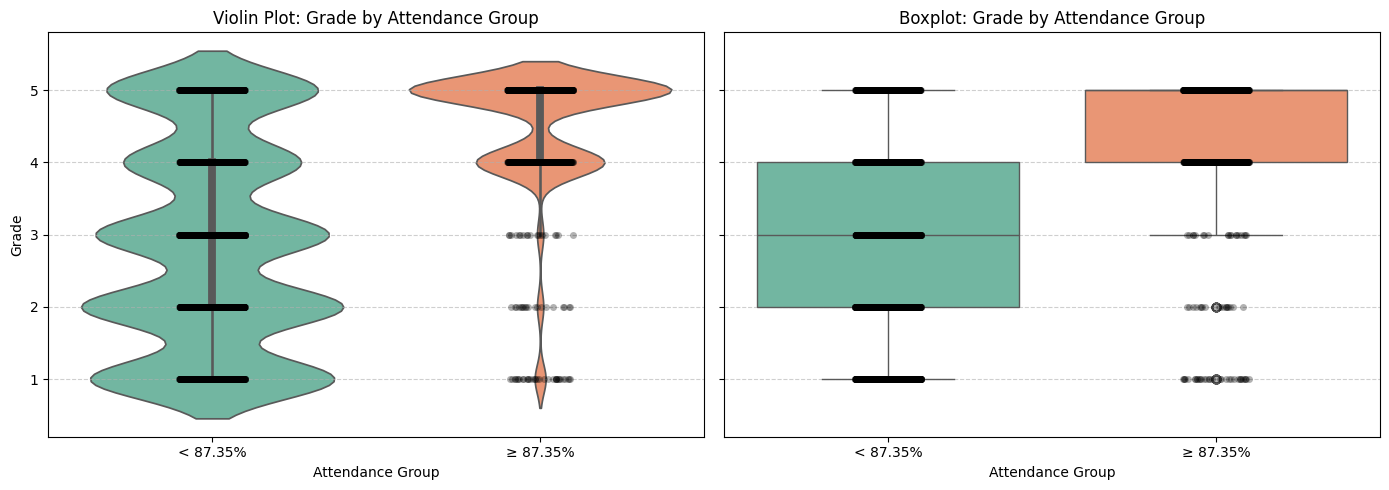

In [85]:
plot_attendance_vs_grade_best(df)

- ✅ The plot demonstrated visualy with  Mann-Whitney U Test that we indeed have the strong associasion.

---


Therefore, we will explore whether there is a relationship between stress_level, attendance, and grade.

> ✳️ **H0 (Null Hypothesis):** There is no difference in grades or attendance across stress levels.
> 
> ✳️ **H1 (Alternative Hypothesis):** At least one stress level group has significantly different grades or attendance.

To do this, we’ll use the 🧪 `Kruskal-Wallis` test, a non-parametric statistical method that’s similar to the 🧪 `Mann-Whitney U test`, but designed for comparing three or more independent groups to first check it.

>🔎 Do students with different stress levels tend to have different grades and attendance?

In [86]:
df['stress_group'] = pd.qcut(df['stress_level'], q=5, labels=['Low', 'Medium', 'High', 'Super', 'Extreme'])

# Now we apply the test
groups = [g['grade'].values for _, g in df.groupby('stress_group', observed=False)]
stat, p = kruskal(*groups)

print(f"Grades — Kruskal-Wallis test: H={stat:.4f}, p-value={p:.4f}")

Grades — Kruskal-Wallis test: H=9.9691, p-value=0.0410



- ✅ With that have statistically significant evidence to reject the null hypothesis!!

This suggests that at least one of the stress groups differs significantly in terms of student grades.

interpretation:
> 📌 At least one of the stress groups differs significantly in terms of student grades.

Since the Kruskal-Wallis test tells you that there's a difference, but not where, we will do a further analysis

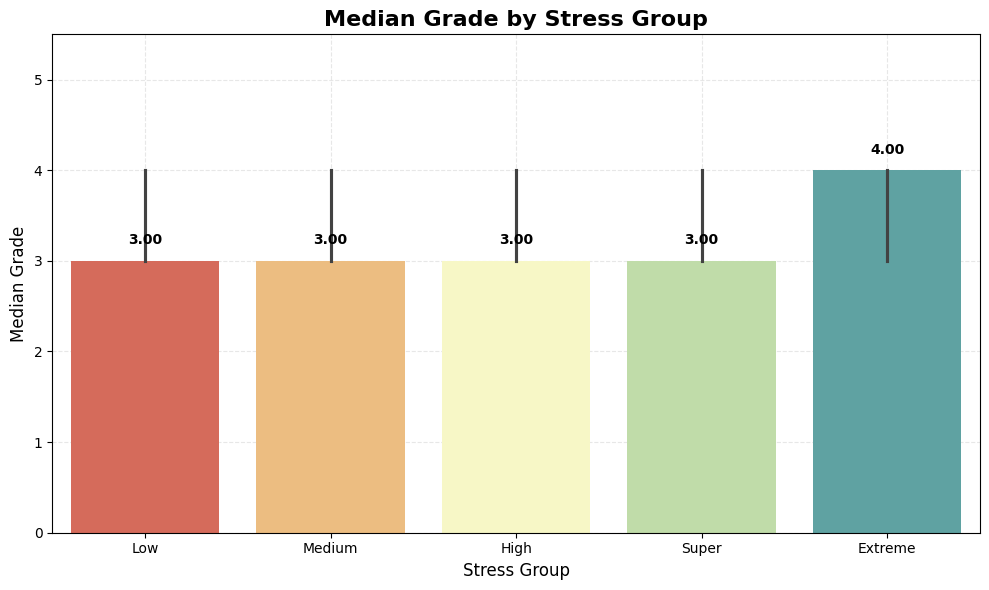

In [87]:
plot_median_grade_by_stress_group(df)

Interpretation:
>    💡 Students in the Extreme stress group have higher grades — likely due to pressure-driven performance

**🔥classic “stress-as-a-motivator” theory 🔥**

This supports a nonlinear pattern, possibly:
- Mild to moderate stress → neutral effect
- **Extreme stress → pushes some students to perform better**

But maybe it is not sustainable or healthy in the long run...

Let`s validate this finding:

In [88]:
# pairwise Mann-Whitney Test, result commented for a better visualisation graph
results = pairwise_mwu(df, 'stress_group', 'grade')
#pd.DataFrame(results)

In [89]:
groups = [g['grade'].values for _, g in df.groupby('stress_group', observed=False)]
stat, p = kruskal(*groups)

🧪 **Pairwise Mann-Whitney U — Grades by 5-Level Stress Group**

| Comparison          | p-value   | Significant? | Meaning |
|---------------------|-----------|--------------|---------|
| **Low vs Extreme**  | **0.0079** ✅ | **Yes** | Extreme stress students outperform Low stress students |
| **Extreme vs Super**| **0.0053** ✅ | **Yes** | Extreme stress group scores higher than the Super stress group |
| All others          | > 0.10     | ❌ No        | Not statistically different |

Interpretation:

>💡 Students in the **Extreme stress group** scored **significantly higher** than **Low stress** students and even **Super stress** students

- No other comparisons were significant — even **Medium vs High** or **High vs Extreme** were not.

🧠 What This Suggests:

This result aligns **perfectly** with a common psychological pattern:

> **Moderate stress ≈ neutral**  
> **Extreme stress** (likely short-term, pressure-driven) can lead to **high performance**, perhaps due to adrenaline, deadline urgency, or hyperfocus.

### 🎯 Key Insight:
- Academic performance **does not consistently increase with stress**
- It **jumps at the highest level** —> suggesting that only **a specific kind of stress** improves grades

---
Now that we know that Stress level shows a subtle relationship with grade, can we suppose that it also holds true for total_score?

> 🔎 Do students with different stress levels tend to have different total_scores ?

In [90]:
## Now let`s test it
groups = [g['total_score'].values for _, g in df.groupby('stress_group', observed=False)]
stat, p = kruskal(*groups)
print(f"Total Score — Kruskal-Wallis test: H={stat:.4f}, p-value={p:.4f}")

Total Score — Kruskal-Wallis test: H=3.3940, p-value=0.4942


Interpretation:
> 📌 There is no significant difference in total_score across stress groups.

Ok, no relationship with total_score, what about attendance?

In [91]:
groups = [g['attendance'].values for _, g in df.groupby('stress_level' , observed=False)]
stat, p = kruskal(*groups)
print(f"Attendance — Kruskal-Wallis test: H={stat:.4f}, p-value={p:.4f}")

Attendance — Kruskal-Wallis test: H=8.9678, p-value=0.4403


Interpretation:
> 📌 There is **no** statistically significant difference in `attendance` across different `stress` levels

---

New Goal:
> 🎯 how study hours and sleep_hours_per_night relate to grade and total_score

- **How study hours affect grade?**

> ✳️ **Null Hypothesis (H0):** There is no difference in grade between students with high study hours

> ✳️ **hypothesis (H1):** There is difference !

In [92]:
## group them
df['study_group'] = pd.qcut(df['study_hours_per_week'], q=3, labels=['Low', 'Medium', 'High'])

In [93]:
# Grade vs Study hours
study_groups = [g['grade'].values for _, g in df.groupby('study_group', observed=False)]
stat, p = kruskal(*study_groups)
print(f"Study Hours → Grade: H={stat:.4f}, p-value={p:.4f}")

Study Hours → Grade: H=1.5966, p-value=0.4501


> 🔎 To better visualize we gonna plot a scatter plot 

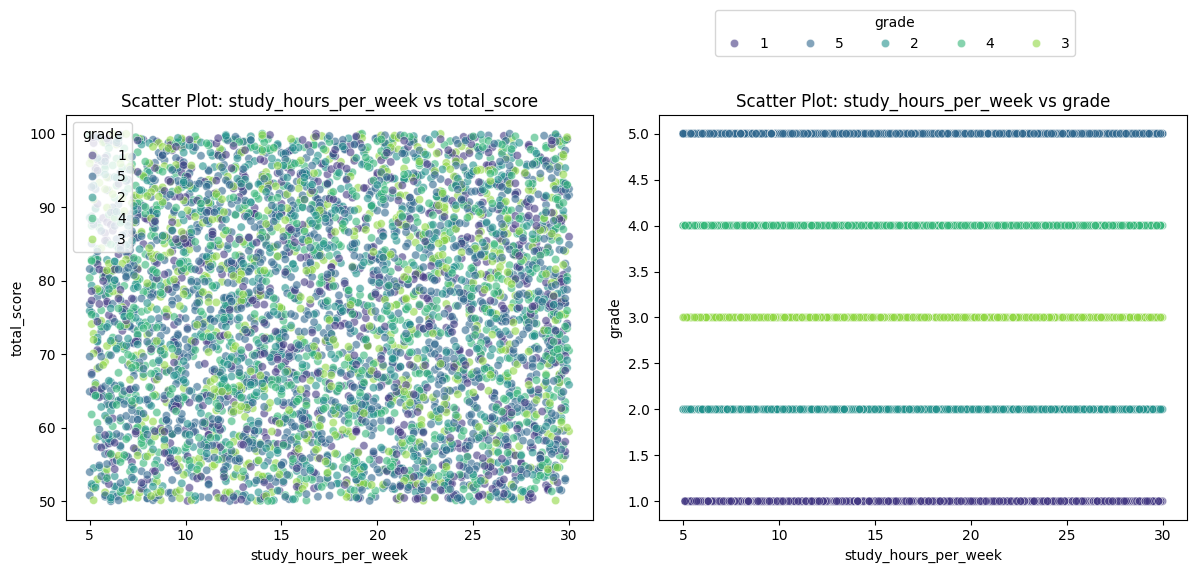

In [94]:
plot_scatter(df, x_y_pairs=[('study_hours_per_week', 'total_score'), ('study_hours_per_week', 'grade')], hue_col='grade')

📊 **Interpretation**

> 📌 There is **no statistically significant difference** in grades across **different levels of weekly study hours**.

This result is surprising but at the same time expected. It suggests that **academic success may not be directly related to the quantity of study hours alone**. 

Instead, it highlights an important classic insight:  
> ✅ **The `quality` of study matters more than the `quantity`.**

Other Factors such as study efficiency, focus, stress management, and overall learning strategies might play a more critical role than simply putting in more hours.

---

- **How Sleep hours affect grade?**

> ✳️ **Null Hypothesis (H0):** There is no difference between them! -
> ✳️ **hypothesis (H1):** There is difference !

In [95]:
df['sleep_group'] = pd.qcut(df['sleep_hours_per_night'], q=3, labels=['Low', 'Medium', 'High'])
sleep_groups = [g['grade'].values for _, g in df.groupby('sleep_group', observed=False)]
stat, p = kruskal(*sleep_groups)
print(f"Sleep → Grade: H={stat:.4f}, p-value={p:.4f}")

Sleep → Grade: H=9.0025, p-value=0.0111


Interpretation:

- ✅ We reject the null hypothesis
    - ✳️ Null Hypothesis (H0): There is no difference between students sleep and grade.

Therefore:
> 💡 There is a significant statistical difference ! in at least one sleep group has different grades.

This suggests that sleep habits are meaningfully associated with academic performance!

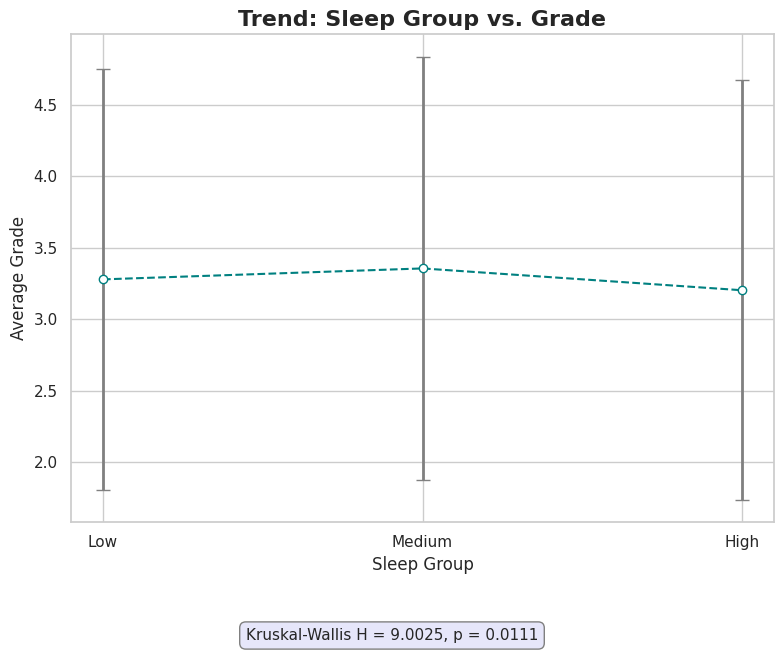

In [96]:
plot_group_trend(df, group_column='sleep_group', value_column='grade')

---

Interpretation:

 - ✅ We Know now that sleep afect grades. but how? the plotting is giving us some insights... 

🔍 Research Question
> ✳️ Do Students with too little or too much sleep get lower grades → inverted U-shaped curve ?

For that we will do a pair comparision between the groups, to better evidenciate it.

- Categorical Pairwise Comparison

#### What is it?
- Tests if the **distribution of values** in one group is **shifted** relative to another

---

In [97]:
# test
results = pairwise_mwu(df, 'sleep_group', 'grade')
#pd.DataFrame(results)

Interpretation 🧠 :
> - 💡 Students who **sleep excessively** perform **worse** than those with **moderate sleep**

- **Only the High vs Medium** group showed a statistically significant difference.
- Low sleep didn’t significantly differ, though a slight trend was observed.

**✅ Conclusion:**

> The **categorical analysis revealed** that **moderate sleep is associated with better grades** than excessive sleep.  
> These findings support the idea that **too much sleep may reduce academic performance**, even if **too little** doesn't have a significant direct effect.

Since we found that sleep influences grades, it's logical to ask:

>Does sleep also affect attendance?
>
---

🧭 New Goal:

> ✳️ Test whether students who sleep more or less tend to have different attendance rates.

let`s see if we can find how sleep might influence attendance, and whether it could mediate the effect on grades.

> ✳️ **Null Hypothesis (H0):** Sleep has **no** influence in attendance.

> ✳️ **hypothesis (H1):**  Sleep has influence in attendance.

In [98]:
groups = [g['attendance'].values for _, g in df.groupby('sleep_group', observed=False)]
stat, p = kruskal(*groups)
print(f"Sleep → Attendance — Kruskal-Wallis test: H={stat:.4f}, p-value={p:.4f}")

Sleep → Attendance — Kruskal-Wallis test: H=10.8260, p-value=0.0045


Interpretation:

* With **[p < 0.01]** → We reject the null hypothesis 

This means:
> 🎯 There is a statistically significant difference in attendance across the sleep groups

**That’s  significant result and This opens up a deeper insight! 🔥**
- Maybe students who sleep too little or too much are more likely to miss class
- And since attendance is the strongest predictor of grades in your dataset, this could be a mediating path

> **Sleep → Attendance → Grade**

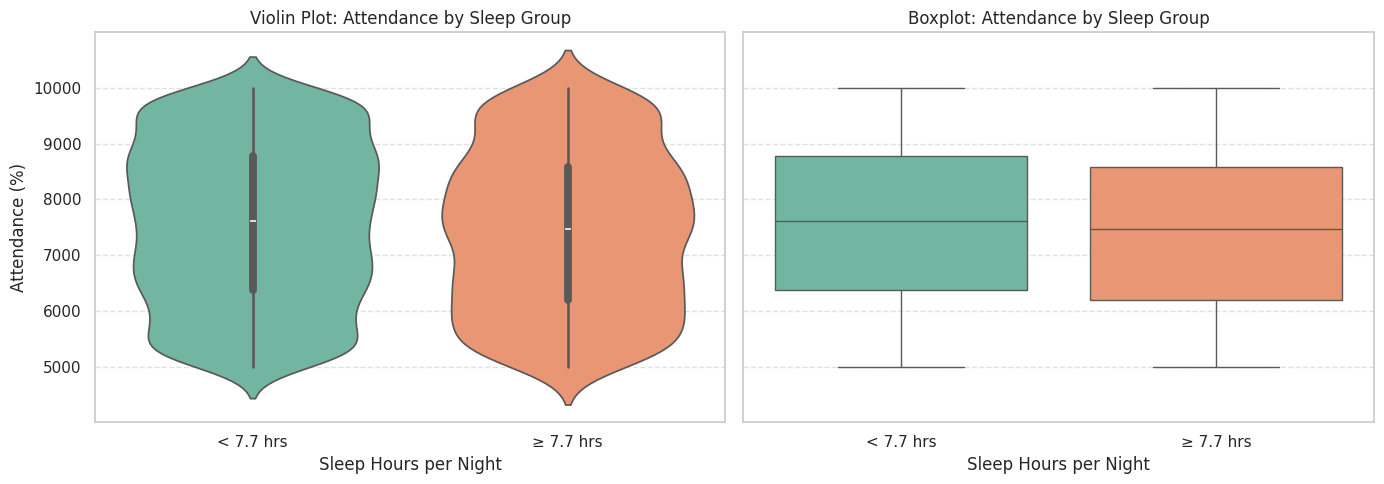

In [99]:
plot_sleep_vs_attendance(df)

Therefore, while more sleep is often linked to better performance, in this data it correlates with modestly lower class attendance!
And if class attendance affect the grade, could indirectly affect the grade!

To proove further, we will again the: 🧪 **Pairwise Mann-Whitney U — Attendance by Sleep Group**


In [100]:
results = pairwise_mwu(df, 'sleep_group', 'attendance')
#pd.DataFrame(results)

 🧪 **Pairwise Mann-Whitney U — Good Visual Representantion**
| Comparison         | p-value   | Interpretation                  |
|--------------------|-----------|----------------------------------|
| **Low vs High**    | **0.0079** | ✅ Significant difference        |
| **Low vs Medium**  | 0.7058     | ❌ No significant difference     |
| **High vs Medium** | **0.0025** | ✅ Significant difference        |

🧠 Interpretation:

- **High sleepers** have **significantly different attendance** from both **Low** and **Medium** groups
- **Medium vs Low** → No difference
- So again... 🎯 **Medium sleep** appears to be optimal
- **High sleepers are likely attending less**

---

**🧩 Combined Insight: Sleep → Attendance → Grade**

Let’s put it all together now:

1. **Sleep group significantly affects grade** → (Kruskal-Wallis, p = 0.0111)
2. **Sleep group significantly affects attendance** → (Kruskal-Wallis, p = 0.0045)
3. **Attendance is strongly correlated with grade** → (ρ ≈ 0.54)

**✅ What This Suggests**

> **Students who sleep too much** may be **missing more classes!!**, and that **lower attendance** could explain their **lower performance**.

This supports a **mediated relationship** like:

```
Sleep Quality (High Sleep) 
      ↓
  Lower Attendance
      ↓
     Lower Grade
```

---

🎯 New Objective:

> **To explore whether Socioeconomic Factors such as income level and parental education are associated with student academic performance.**

In [101]:
## Verify again
df['family_income_level'].unique()

array(['Medium', 'Low', 'High'], dtype=object)

In [102]:
# Extract 'grade' values for each group
low_grades    = df.loc[df['family_income_level'] == "Low",    'grade'].dropna()
medium_grades = df.loc[df['family_income_level'] == "Medium", 'grade'].dropna()
high_grades   = df.loc[df['family_income_level'] == "High",   'grade'].dropna()

# Perform Kruskal-Wallis test
stat, p = kruskal(low_grades, medium_grades, high_grades)
print(f"Kruskal-Wallis: H-stat={stat:.4f}, p={p:.4f}")

Kruskal-Wallis: H-stat=0.1573, p=0.9244


Interpretation:
>📌 There is no meaningful difference in grades between Low, Medium, and High income groups

Let`s confirm it by looking at the high against the others:

In [103]:

low_grades    = df.loc[df['family_income_level'] == "Low",    'attendance'].dropna()
medium_grades = df.loc[df['family_income_level'] == "Medium", 'attendance'].dropna()
high_grades   = df.loc[df['family_income_level'] == "High",   'attendance'].dropna()

# Perform Kruskal-Wallis test
stat, p = kruskal(low_grades, medium_grades, high_grades)
print(f"Kruskal-Wallis: H-stat={stat:.4f}, p={p:.4f}")

Kruskal-Wallis: H-stat=2.3696, p=0.3058


Interpretation:

> 📌 There is no meaningful difference in Attendance between Low, Medium, and High income groups

So in a geral it does not have a relationship, let`s further explore how much the high income differs.

In [104]:
high_grades = df.loc[df['family_income_level'] == 'High', 'grade']
other_grades = df.loc[df['family_income_level'] != 'High', 'grade']

stat, p = mannwhitneyu(high_grades, other_grades, alternative='two-sided')
print(f"Grade ~ (Other vs High Income) — Mann-Whitney: U={stat:.4f}, p={p:.4f}")

Grade ~ (Other vs High Income) — Mann-Whitney: U=2071127.5000, p=0.8803


It confirmns that: 
> ✅ **Family income level does not significantly affect either grades  in this dataset.**

Let’s now test:

> ❓ Does the parent’s education level affect students’ academic performance?

- ✳️ **Null Hypothesis (H0):** There is No relationship between academic performance and parents education.

- ✳️ **hypothesis (H1):** There is difference.

In [105]:
df['parent_education_level'].value_counts()

parent_education_level
Unknown        1794
PhD             820
Bachelor's      810
High School     796
Master's        780
Name: count, dtype: int64

In [106]:
# lets calculate if there is a relationship
groups = [g['grade'].values for _, g in df.groupby('parent_education_level', observed=False)]
stat, p = kruskal(*groups)
print(f"Grades ~ Parent Education (known only): H={stat:.4f}, p={p:.4f}")

Grades ~ Parent Education (known only): H=3.6937, p=0.4490


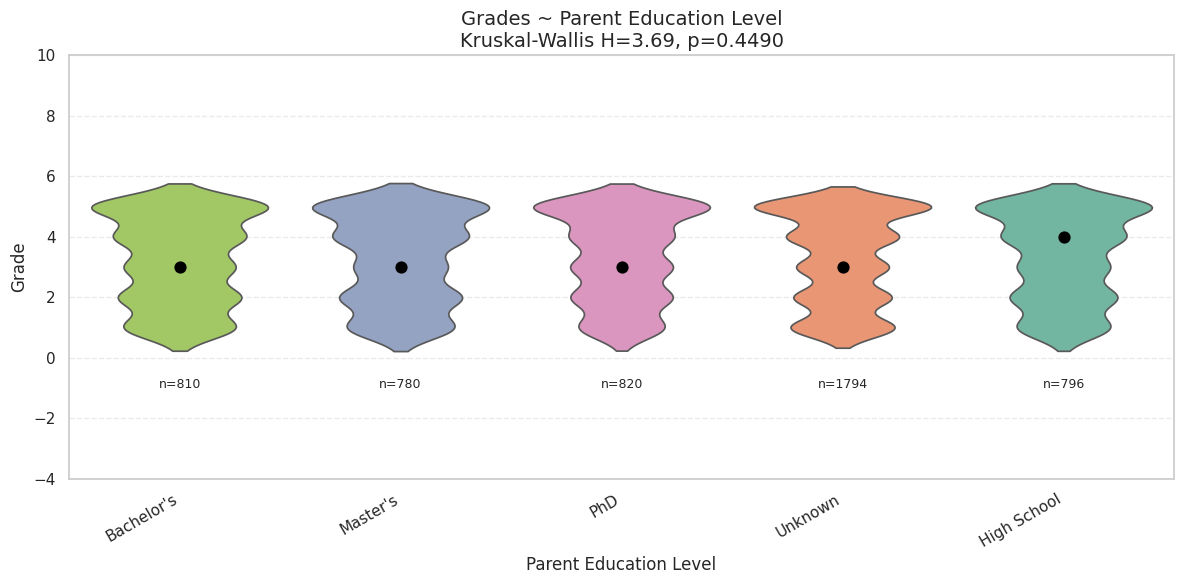

In [107]:
plot_grades_by_parent_education(df)

In [108]:
# Final verification of the data without the inputed Uknown
known_edu = df[df['parent_education_level'] != 'Unknown']

groups = [g['grade'].values for _, g in known_edu.groupby('parent_education_level', observed=False)]
stat, p = kruskal(*groups)
print(f"Grades ~ Parent Education (known only): H={stat:.4f}, p={p:.4f}")

Grades ~ Parent Education (known only): H=3.7313, p=0.2920


Interpretation:

🧪 Kruskal-Wallis Tests:
- **Including “Unknown”** → H = 3.6937, p = 0.4490 ❌  
- **Excluding “Unknown”** → H = 3.7313, p = 0.2920 ❌

✅ **Conclusion:**  
> **Parental education level does not significantly affect student grades**, even when isolating only known values.


# D. 🔍 Conclusion

### 🧩 The Whole Picture

| Factor                    | Affects Grade? | Affects Attendance? | Notes                                             |
|---------------------------|----------------|----------------------|---------------------------------------------------|
| **Parent Education Level**| ❌ No           | Not tested           | No significant impact on grades                   |
| **Family Income Level**   | ❌ No           | ❌ No                | Consistently insignificant across all tests       |
| **Attendance**            | ✅ Yes          | —                    | **Strongest predictor** (Spearman ρ ≈ 0.54)       |
| **Sleep**                 | ✅ Yes (nonlinear) | ✅ Yes             | Moderate sleep is **optimal**; extremes reduce performance |
| **Stress (Extreme only)** | ✅ Yes          | —                    | Only **Extreme stress** linked to higher grades   |


### 😴 Sleep and Attendance — Deeper Analysis

Our findings revealed that **sleep patterns significantly influence both academic performance and attendance behavior** — and importantly, the relationship is **nonlinear**.

---

#### 🧪 Statistical Evidence:

- **Kruskal-Wallis tests** showed that:
  - **Sleep group → Grades**: H = 9.0025, **p = 0.0111**
  - **Sleep group → Attendance**: H = 10.8260, **p = 0.0045**

- **Pairwise Mann-Whitney U tests** revealed:
  - Students in the **High Sleep group** (top 33%) had **significantly lower attendance** than those in the **Medium Sleep group**
  - They also had **significantly lower grades** than Medium sleepers

---

#### 🧠 Interpretation:

- **Too little or too much sleep** may be disruptive:
  - **Low sleep** might impair focus and memory
  - **High sleep** may be associated with oversleeping, irregular routines, or disengagement

- **Moderate sleep** (central quantile) emerged as the **most academically beneficial**:
  - These students had the **highest median grades**
  - They also had **the best attendance**, suggesting stronger discipline or healthier routines

- This relationship implies that **the effect of sleep on academic performance may be both direct and indirect**:
  - Direct: through cognitive function and energy levels
  - Indirect: by influencing class attendance

---

#### 🔁 Possible Causal Flow:


```
Sleep Duration
     ↓
Attendance Behavior
     ↓
Academic Performance
```

> Sleep is not just a health habit — it's an **academic behavior**.  
> Students who sleep **too much** are more likely to **miss class** and perform worse.  
> Those with **moderate, balanced sleep schedules** are **more consistent, more present, and more successful** overall.

---

Let me know if you'd like this adapted into a slide format, or tied into a full "Recommendations" section next.
###  Key Finding on Stress:

When stress was categorized into five levels, a **nonlinear pattern** emerged:

> Students in the **Extreme stress group** scored significantly higher than those in both **Low** and **Super** stress groups.  
> While mild to moderate stress showed **no meaningful effect**, this result suggests that **very high, acute stress may enhance academic performance**, possibly due to increased urgency, focus, or motivation.

---

### 🧠 Insight on Socioeconomic Background:

Although **family income** and **parent education** are often linked to long-term educational opportunity and access, in this dataset:

> There is **no direct or statistically significant association** between these background factors and student academic performance.

Even after excluding "Unknown" values in the parental education data, **no difference in grades was found** across educational levels from high school to PhD!


> While socioeconomic background is commonly assumed to affect academic outcomes, this analysis found **no evidence that income level or parental education significantly influence grades or attendance**.  
> Instead, **academic success in this population is more closely tied to behavioral and situational factors** — especially **consistent attendance**, **optimal sleep patterns**, and the presence of **extreme (though likely unsustainable) stress**.

---


## 📌 Final Takeaway

> This analysis shows that **student performance is driven more by behavioral and situational factors than by background characteristics**.  
> In this population, the students who succeed are not necessarily those from wealthier or more educated families — they are the ones who:
- **Attend class regularly**
- **Sleep moderately**
- And in some cases, **perform well under pressure**